In [ ]:
!curl ipinfo.io

{
  "ip": "35.234.14.34",
  "hostname": "34.14.234.35.bc.googleusercontent.com",
  "city": "Taipei",
  "region": "Taiwan",
  "country": "TW",
  "loc": "25.0478,121.5319",
  "org": "AS396982 Google LLC",
  "timezone": "Asia/Taipei",
  "readme": "https://ipinfo.io/missingauth"
}

In [ ]:
!pip install yfinance pmdarima statsmodels arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 29.0 MB/s eta 0:00:00


# 1. PACKAGE IMPORTING AND DATA COLLECTION


## 1.1 Import dependencies

In [ ]:
# Standard library imports
import os
import sys
import math
import warnings
import itertools
from math import sqrt
from datetime import datetime
from itertools import product
from datetime import datetime, timedelta

# Third-party library imports
from arch import arch_model
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pmdarima import auto_arima
from pandas.plotting import lag_plot
from pandas_datareader import data as pdr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model
from keras.models import Sequential

# IPython display
from IPython.display import Image, display, HTML

# Matplotlib configuration
# rcParams['figure.figsize'] = 10, 6

In [ ]:
warnings.filterwarnings("ignore")
# Use a consistent style
plt.style.use('seaborn')

## 1.2  Download Data and tickers

In [ ]:
# Download data
TICKER = "TSLA"
target_column = 'Close'
df = yf.download(TICKER, start="2018-01-01", end="2024-01-01").reset_index()

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Split the data into training and test sets
split_date = df.index[int(len(df) * 0.8)]
train = df[:split_date]
test = df[split_date:]

In [ ]:
df[['Open', 'High',	'Low',	'Close',	'Adj Close',	'Volume']].describe()

,Open,High,Low,Close,Adj Close,Volume
count,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1.509000e+03
mean,146.023254,149.313587,142.479038,145.981504,145.981504,1.332430e+08
std,113.661210,116.141645,110.885498,113.530192,113.530192,8.365567e+07
min,12.073333,12.445333,11.799333,11.931333,11.931333,2.940180e+07
25%,22.250000,22.660000,21.833332,22.271334,22.271334,8.112930e+07
50%,159.663330,161.619995,153.279999,160.190002,160.190002,1.090935e+08
75%,241.770004,246.990005,236.976669,242.190002,242.190002,1.550325e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


In [ ]:
df.dtypes

,0
index,int64
Open,float64
High,float64
Low,float64
Close,float64
Adj Close,float64
Volume,int64


In [ ]:
# Check for missing values
df.isnull().sum()

,0
index,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


## 1.3 Split Data into training and testing sets

In [ ]:
test.head()

,index,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2022-10-18,1207,229.500000,229.820007,217.250000,220.190002,220.190002,75891900
2022-10-19,1208,219.800003,222.929993,217.779999,222.039993,222.039993,66571500
2022-10-20,1209,208.279999,215.550003,202.000000,207.279999,207.279999,117798100
2022-10-21,1210,206.419998,214.660004,203.800003,214.440002,214.440002,75713800
2022-10-24,1211,205.820007,213.500000,198.589996,211.250000,211.250000,100446800


In [ ]:
train.head()

,index,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2018-01-02,0,20.799999,21.474001,20.733334,21.368668,21.368668,65283000
2018-01-03,1,21.400000,21.683332,21.036667,21.150000,21.150000,67822500
2018-01-04,2,20.858000,21.236668,20.378668,20.974667,20.974667,149194500
2018-01-05,3,21.108000,21.149332,20.799999,21.105333,21.105333,68868000
2018-01-08,4,21.066668,22.468000,21.033333,22.427334,22.427334,147891000


In [ ]:
def plot_open_vs_high(df):
    plt.figure(figsize=(10, 6))

    # Scatter plot with 'Date' on x-axis and 'Close' on y-axis
    plt.scatter(df.index, df['Close'], color='blue', edgecolor='black')

    # Set title and labels
    plt.title('Close Price vs Date')
    plt.xlabel('Date')
    plt.ylabel('Close Price')

    # Format the x-axis to show dates clearly
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    plt.grid(True)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

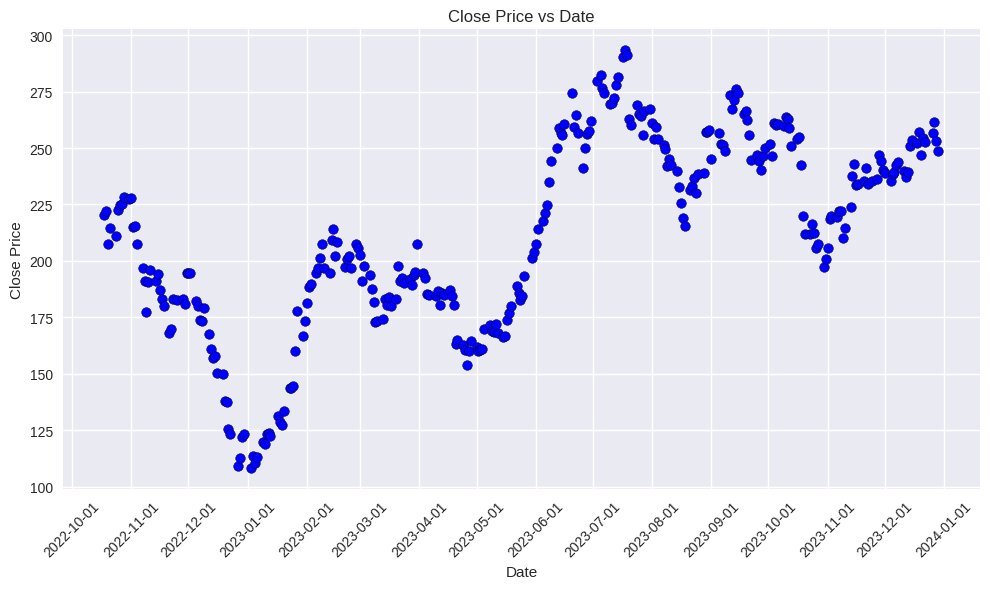

,index,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2022-10-18,1207,229.500000,229.820007,217.250000,220.190002,220.190002,75891900
2022-10-19,1208,219.800003,222.929993,217.779999,222.039993,222.039993,66571500
2022-10-20,1209,208.279999,215.550003,202.000000,207.279999,207.279999,117798100
2022-10-21,1210,206.419998,214.660004,203.800003,214.440002,214.440002,75713800
2022-10-24,1211,205.820007,213.500000,198.589996,211.250000,211.250000,100446800


In [ ]:
plot_open_vs_high(test)
test.head()

# 2. Feature Engineering

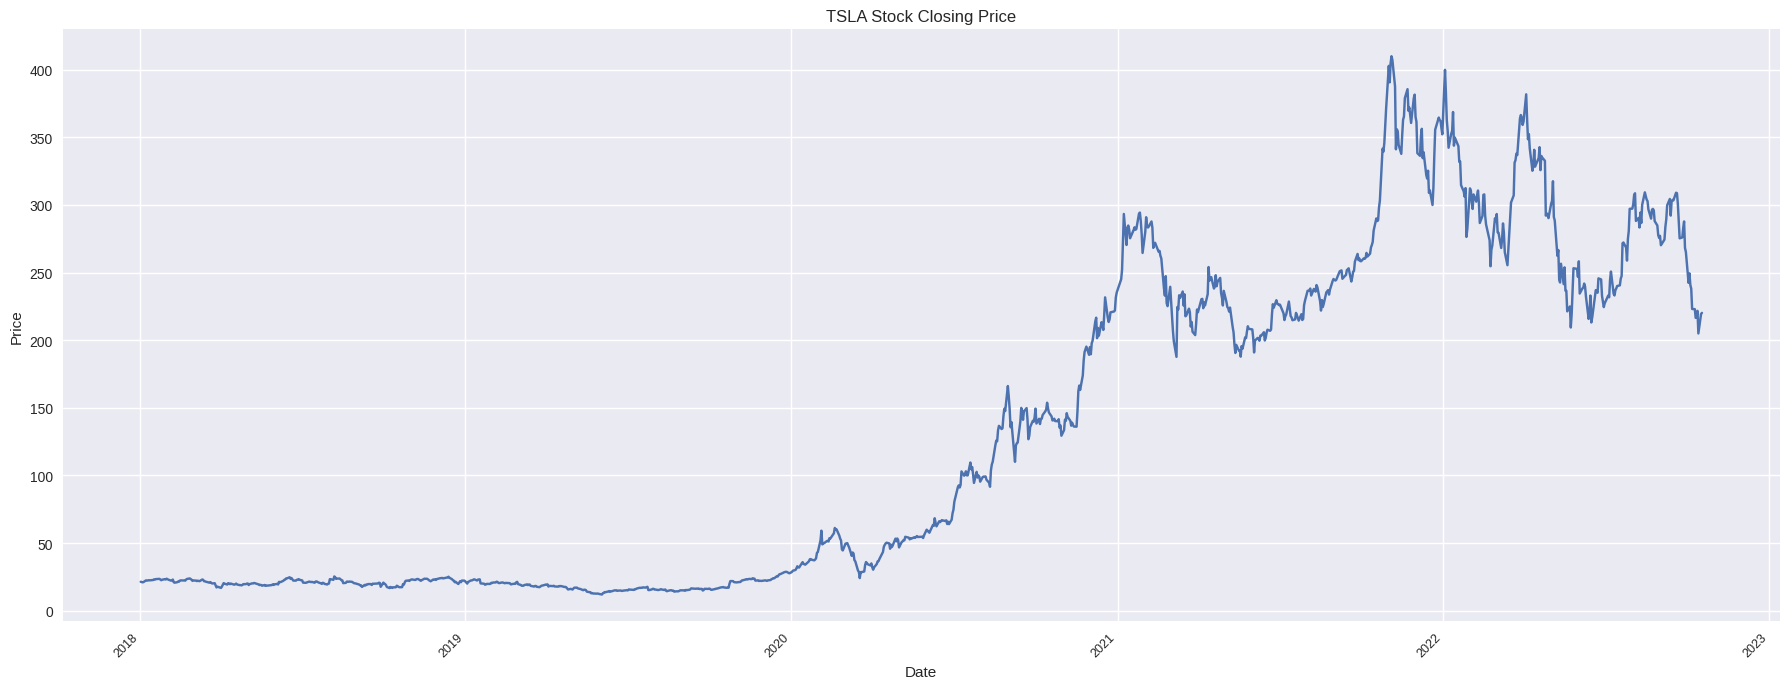

In [ ]:
# Plot the closing price
plt.figure(figsize=(18, 7))
plt.plot(train.index, train['Close'])
plt.title(f'{TICKER} Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.xticks(rotation=45, ha='right', fontsize=9)

plt.tight_layout()
plt.show()

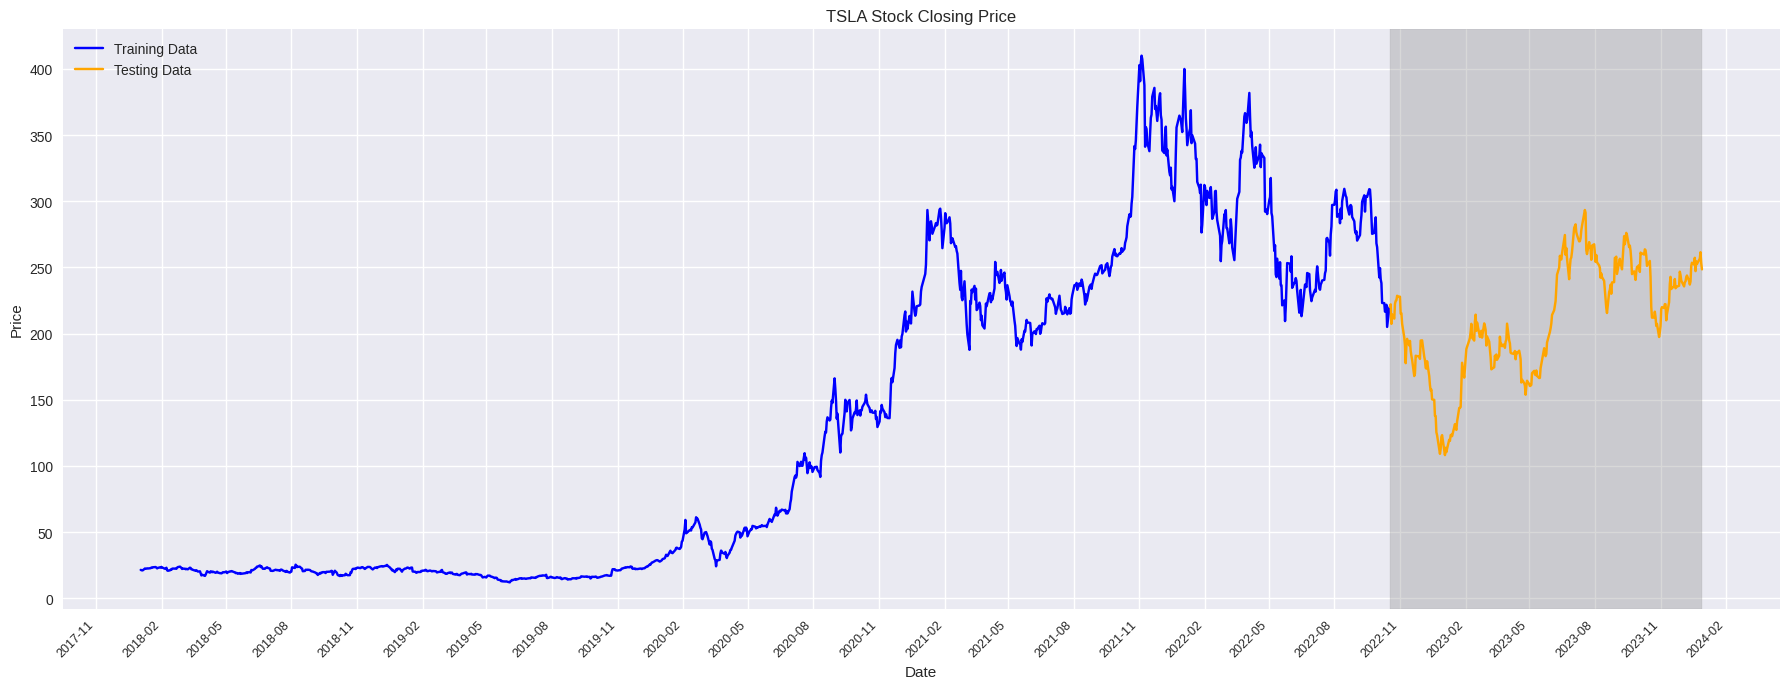

In [ ]:
# Plot the closing price with shading for the testing period
plt.figure(figsize=(18, 7))

# Plot the training data
plt.plot(train.index, train['Close'], label='Training Data', color='blue')

# Plot the testing data
plt.plot(test.index, test['Close'], label='Testing Data', color='orange')

# Shade the testing area
plt.axvspan(test.index[0], test.index[-1], color='gray', alpha=0.3)

# Set the title and labels
plt.title(f'{TICKER} Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')

# Add grid and format the x-axis
plt.grid(True)
plt.xticks(rotation=45, ha='right', fontsize=9)

# Set major ticks to every 3 months and minor ticks to every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Add a legend
plt.legend()

# Adjust layout for better fit
plt.tight_layout()

# Display the plot
plt.show()


## 2.1 Add Extra Features

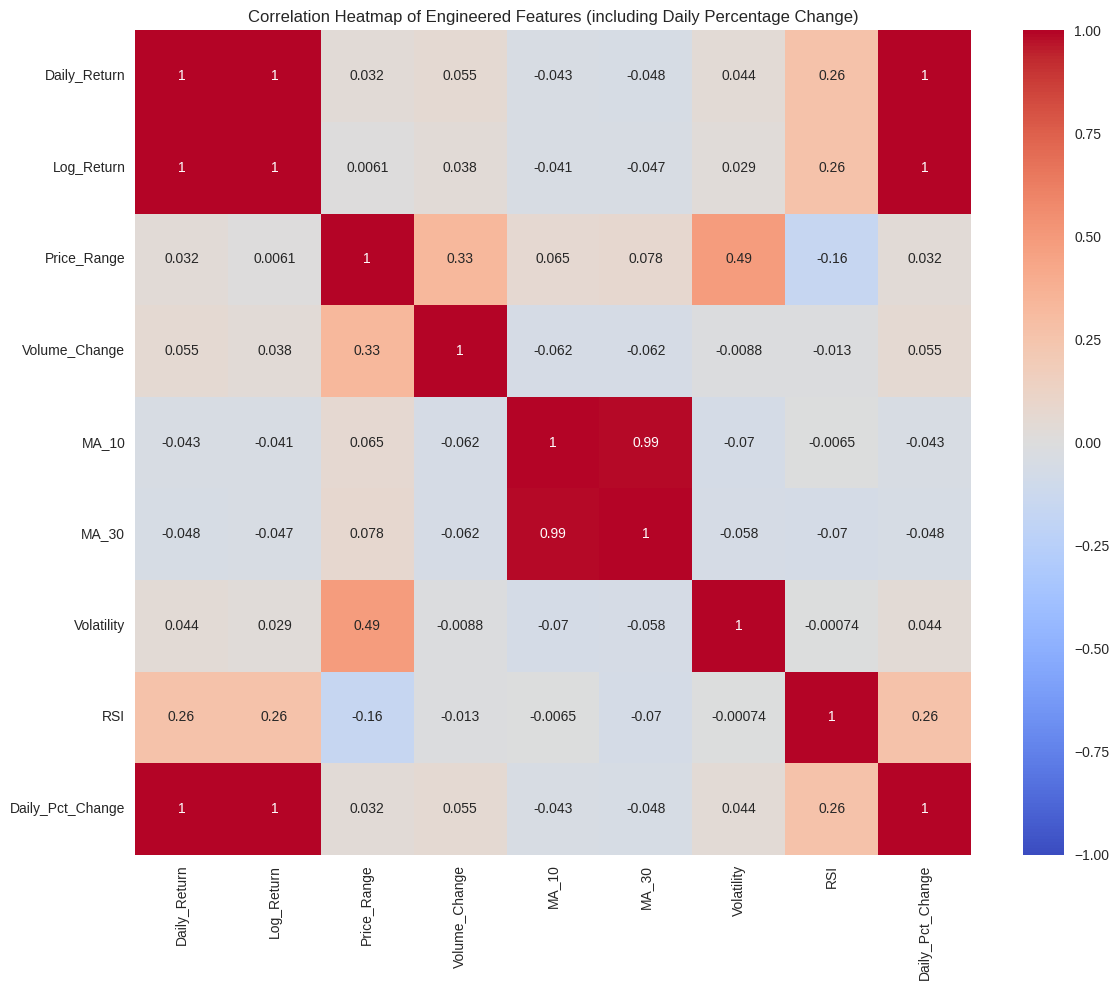

,Daily_Return,Log_Return,Price_Range,Volume_Change,MA_10,MA_30,Volatility,RSI,Daily_Pct_Change
Date,,,,,,,,,
2018-02-13,0.025116,0.024806,0.037077,-0.267767,22.163000,22.400867,0.432062,-21.751961,2.511634
2018-02-14,-0.004171,-0.004180,0.023844,-0.133656,21.949667,22.404822,0.423451,-14.581611,-0.417105
2018-02-15,0.036487,0.035837,0.036117,0.496671,21.848467,22.442200,0.445942,-5.990942,3.648663
2018-02-16,0.004251,0.004242,0.034526,-0.045714,21.793400,22.488578,0.441974,-11.952999,0.425055
2018-02-20,-0.002146,-0.002148,0.027925,-0.289441,21.804334,22.529000,0.441378,-8.993287,-0.214604


In [ ]:
# Feature Engineering (including previous features)
df['Daily_Return'] = df['Close'].pct_change()
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
df['Price_Range'] = (df['High'] - df['Low']) / df['Open']
df['Volume_Change'] = df['Volume'].pct_change()
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['MA_30'] = df['Close'].rolling(window=30).mean()
df['Volatility'] = df['Daily_Return'].rolling(window=20).std() * np.sqrt(252)
df['RSI'] = 100 - (100 / (1 + df['Daily_Return'].rolling(14).mean() / abs(df['Daily_Return']).rolling(14).mean()))

# Add Daily Percentage Change
df['Daily_Pct_Change'] = df['Close'].pct_change() * 100

# Remove rows with NaN values
df_clean = df.dropna()

# Select features for correlation analysis
features = ['Daily_Return', 'Log_Return', 'Price_Range', 'Volume_Change', 'MA_10', 'MA_30', 'Volatility', 'RSI', 'Daily_Pct_Change']

# Calculate correlation matrix
correlation_matrix = df_clean[features].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Engineered Features (including Daily Percentage Change)')
plt.tight_layout()
plt.show()

correlation_matrix

# Display the first few rows of the new dataset
df_clean[features].head()

## 2.3 Plot Stock Analysis Charts

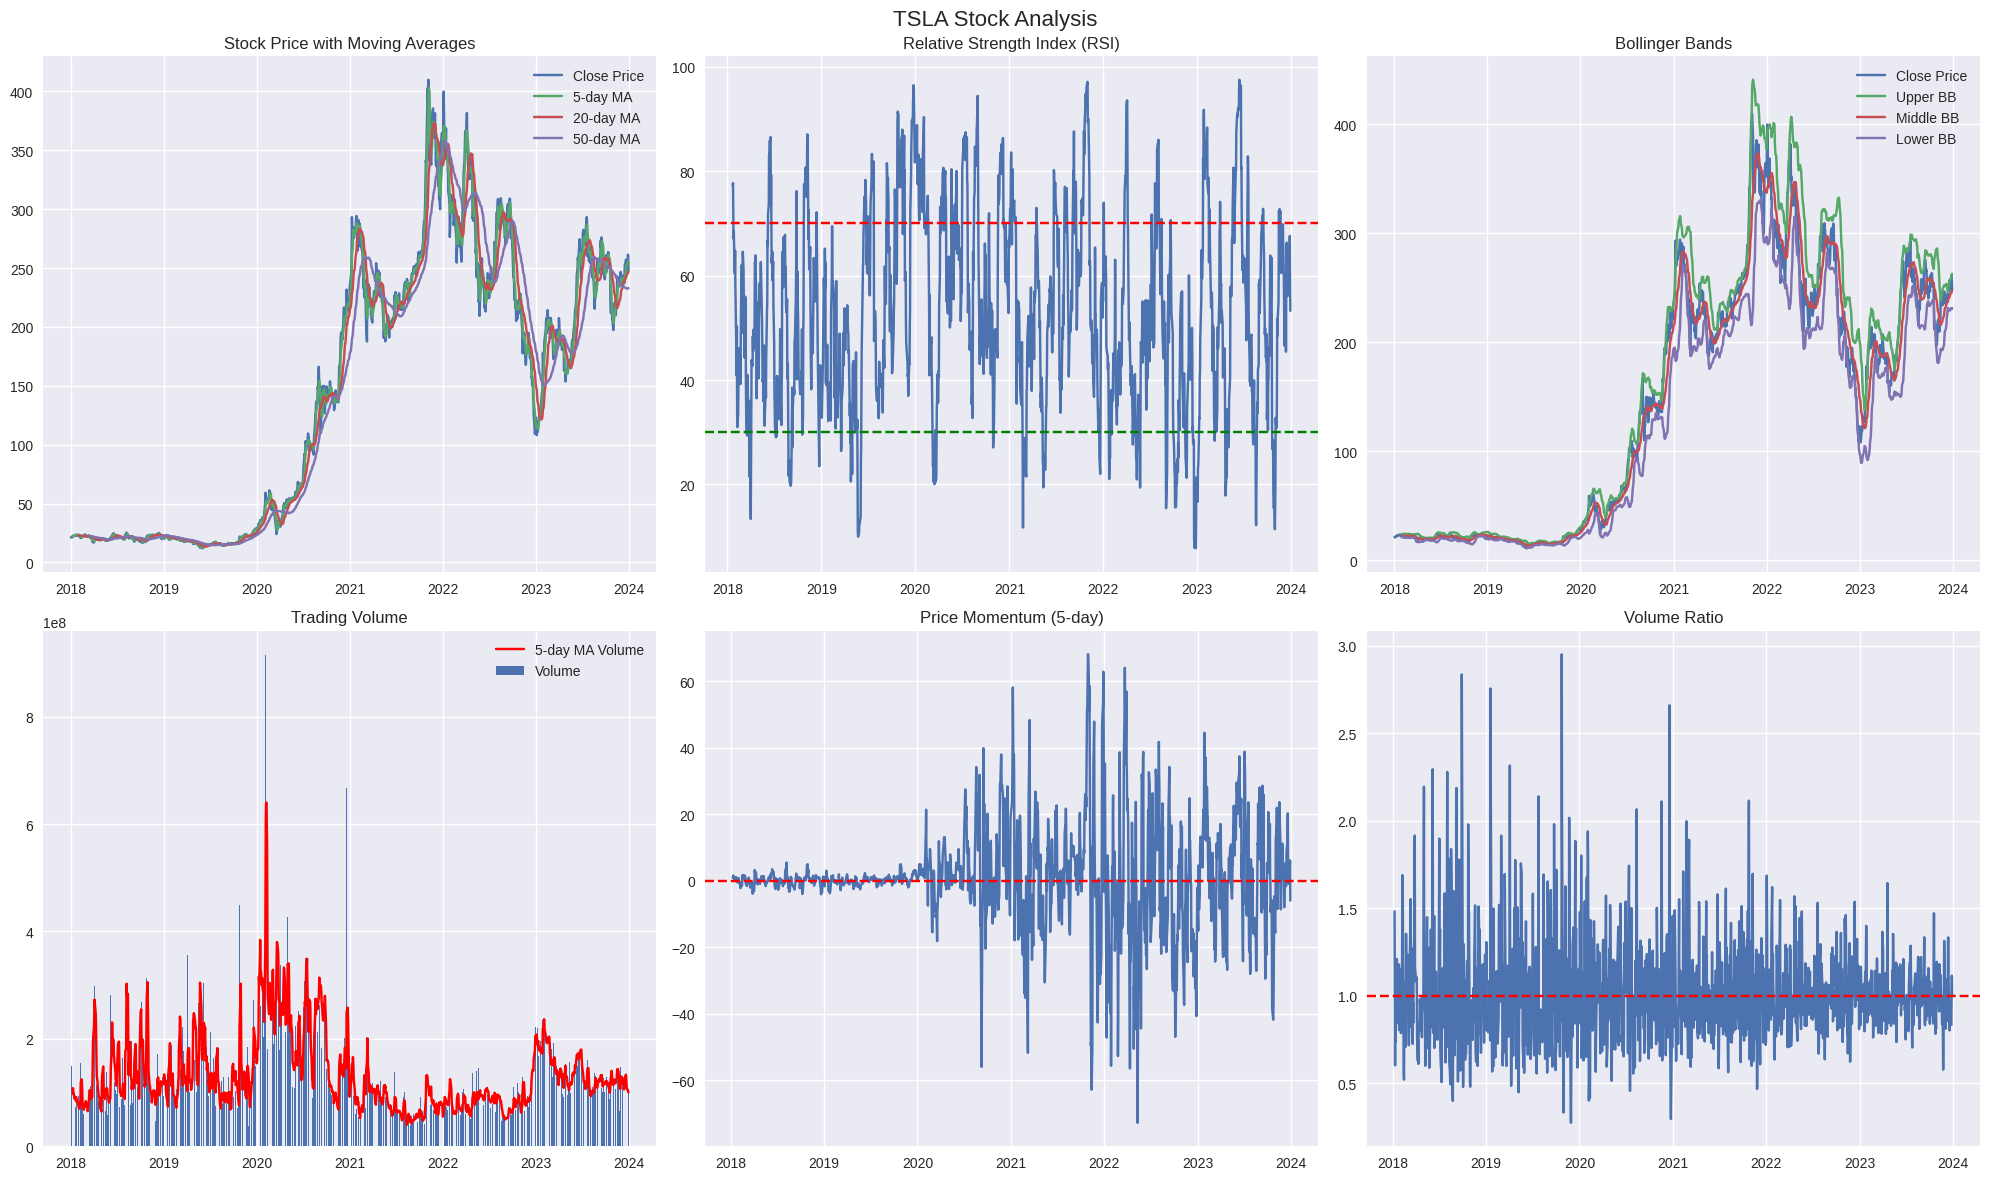

In [ ]:
# Calculate missing columns and add them to the DataFrame
# Moving Averages
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()

# Relative Strength Index (RSI)
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# Bollinger Bands
std = df['Close'].rolling(window=20).std()
df['BB_middle'] = df['MA20']
df['BB_upper'] = df['BB_middle'] + (std * 2)
df['BB_lower'] = df['BB_middle'] - (std * 2)

# Volume Moving Average
df['Volume_MA5'] = df['Volume'].rolling(window=5).mean()

# Price Momentum
df['Price_Momentum'] = df['Close'].diff(periods=5)

# Volume Ratio
df['Volume_Ratio'] = df['Volume'] / df['Volume_MA5']

# Create a figure with 2 rows and 3 columns of subplots
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('TSLA Stock Analysis', fontsize=16)

# 1. Moving Averages
axs[0, 0].plot(df.index, df['Close'], label='Close Price')
axs[0, 0].plot(df.index, df['MA5'], label='5-day MA')
axs[0, 0].plot(df.index, df['MA20'], label='20-day MA')
axs[0, 0].plot(df.index, df['MA50'], label='50-day MA')
axs[0, 0].set_title('Stock Price with Moving Averages')
axs[0, 0].legend()

# 2. RSI
axs[0, 1].plot(df.index, df['RSI'], label='RSI')
axs[0, 1].set_title('Relative Strength Index (RSI)')
axs[0, 1].axhline(y=70, color='r', linestyle='--')
axs[0, 1].axhline(y=30, color='g', linestyle='--')

# 3. Bollinger Bands
axs[0, 2].plot(df.index, df['Close'], label='Close Price')
axs[0, 2].plot(df.index, df['BB_upper'], label='Upper BB')
axs[0, 2].plot(df.index, df['BB_middle'], label='Middle BB')
axs[0, 2].plot(df.index, df['BB_lower'], label='Lower BB')
axs[0, 2].set_title('Bollinger Bands')
axs[0, 2].legend()

# 4. Volume
axs[1, 0].bar(df.index, df['Volume'], label='Volume')
axs[1, 0].plot(df.index, df['Volume_MA5'], color='r', label='5-day MA Volume')
axs[1, 0].set_title('Trading Volume')
axs[1, 0].legend()

# 5. Price Momentum
axs[1, 1].plot(df.index, df['Price_Momentum'], label='Price Momentum')
axs[1, 1].set_title('Price Momentum (5-day)')
axs[1, 1].axhline(y=0, color='r', linestyle='--')

# 6. Volume Ratio
axs[1, 2].plot(df.index, df['Volume_Ratio'], label='Volume Ratio')
axs[1, 2].set_title('Volume Ratio')
axs[1, 2].axhline(y=1, color='r', linestyle='--')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

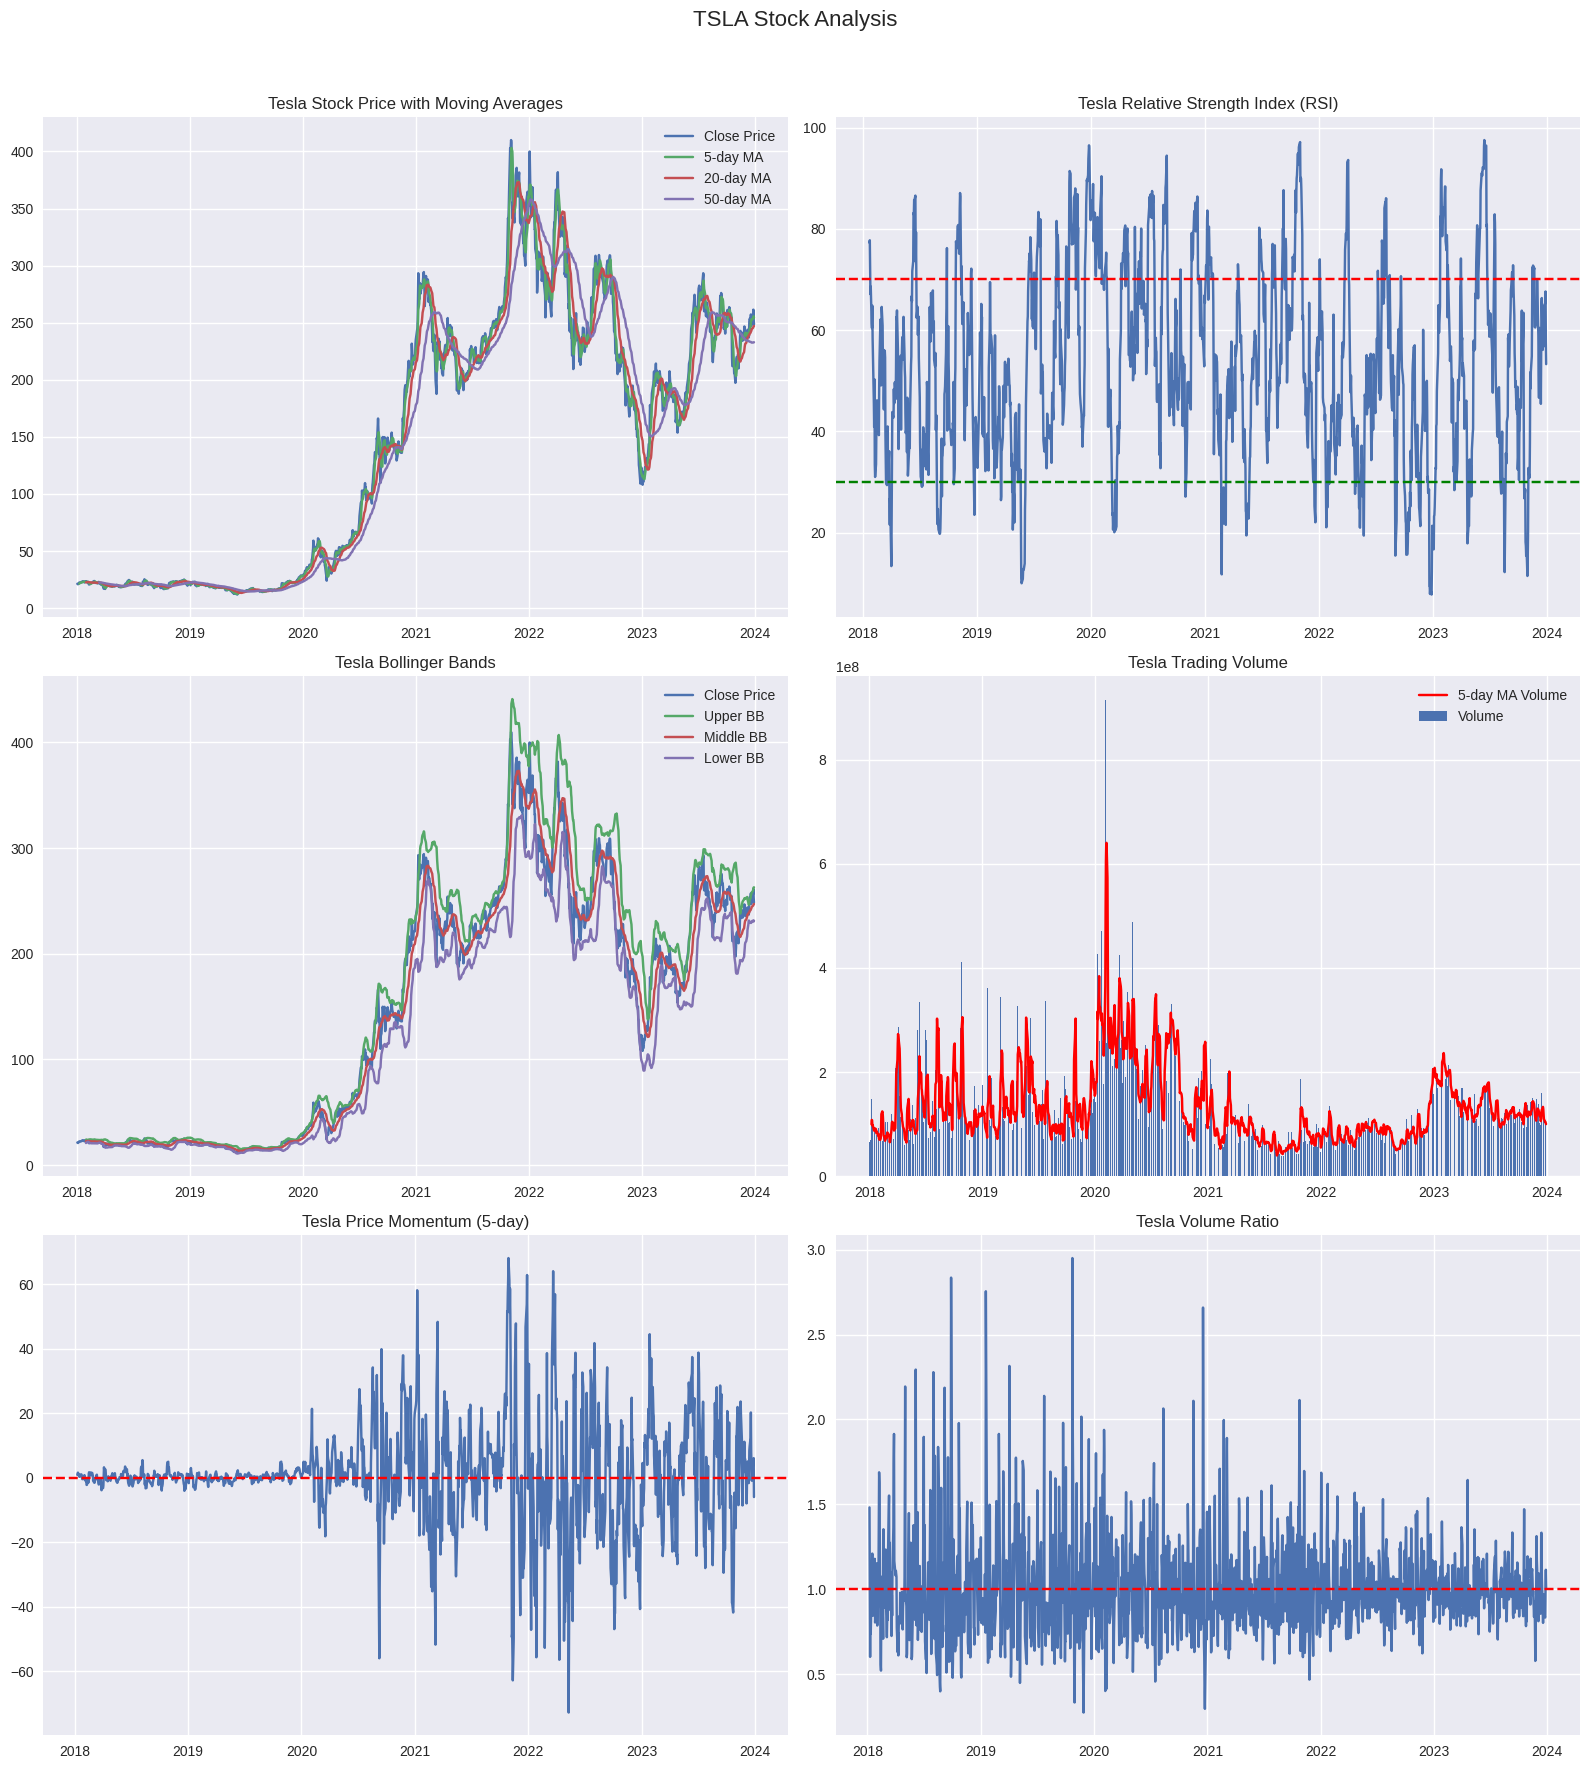

In [ ]:
# Calculate missing columns and add them to the DataFrame
# Moving Averages
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()

# Relative Strength Index (RSI)
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# Bollinger Bands
std = df['Close'].rolling(window=20).std()
df['BB_middle'] = df['MA20']
df['BB_upper'] = df['BB_middle'] + (std * 2)
df['BB_lower'] = df['BB_middle'] - (std * 2)

# Volume Moving Average
df['Volume_MA5'] = df['Volume'].rolling(window=5).mean()

# Price Momentum
df['Price_Momentum'] = df['Close'].diff(periods=5)

# Volume Ratio
df['Volume_Ratio'] = df['Volume'] / df['Volume_MA5']

# Create a figure with 3 rows and 2 columns of subplots
fig, axs = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('TSLA Stock Analysis', fontsize=16)

# 1. Moving Averages
axs[0, 0].plot(df.index, df['Close'], label='Close Price')
axs[0, 0].plot(df.index, df['MA5'], label='5-day MA')
axs[0, 0].plot(df.index, df['MA20'], label='20-day MA')
axs[0, 0].plot(df.index, df['MA50'], label='50-day MA')
axs[0, 0].set_title('Tesla Stock Price with Moving Averages')
axs[0, 0].legend()

# 2. RSI
axs[0, 1].plot(df.index, df['RSI'], label='RSI')
axs[0, 1].set_title('Tesla Relative Strength Index (RSI)')
axs[0, 1].axhline(y=70, color='r', linestyle='--')
axs[0, 1].axhline(y=30, color='g', linestyle='--')

# 3. Bollinger Bands
axs[1, 0].plot(df.index, df['Close'], label='Close Price')
axs[1, 0].plot(df.index, df['BB_upper'], label='Upper BB')
axs[1, 0].plot(df.index, df['BB_middle'], label='Middle BB')
axs[1, 0].plot(df.index, df['BB_lower'], label='Lower BB')
axs[1, 0].set_title('Tesla Bollinger Bands')
axs[1, 0].legend()

# 4. Volume
axs[1, 1].bar(df.index, df['Volume'], label='Volume')
axs[1, 1].plot(df.index, df['Volume_MA5'], color='r', label='5-day MA Volume')
axs[1, 1].set_title('Tesla Trading Volume')
axs[1, 1].legend()

# 5. Price Momentum
axs[2, 0].plot(df.index, df['Price_Momentum'], label='Price Momentum')
axs[2, 0].set_title('Tesla Price Momentum (5-day)')
axs[2, 0].axhline(y=0, color='r', linestyle='--')

# 6. Volume Ratio
axs[2, 1].plot(df.index, df['Volume_Ratio'], label='Volume Ratio')
axs[2, 1].set_title('Tesla Volume Ratio')
axs[2, 1].axhline(y=1, color='r', linestyle='--')

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


#3. Exploratory Data Analysis

In [ ]:
df.isnull().sum()

,0
index,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
Daily_Return,1
Log_Return,1
Price_Range,0


## 3.1 AutoCorrelation and Partial Correlation


>* Autocorrelation is simply the correlation of a series with its own lags. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.

> * Partial Autocorrelation also conveys similar information but it conveys the pure correlation of a series and its lag, excluding the correlation contributions from the intermediate lags.

### 3.1.1 ACF

Autocorrelation, sometimes known as serial correlation, is the correlation of a time series with a delayed copy of itself as a function of delay. That is, it measures the similarity between observations as a function of the time lag between them. The autocorrelation function can be used basically to detect non-randomness in data and identify cyclical patterns if present.

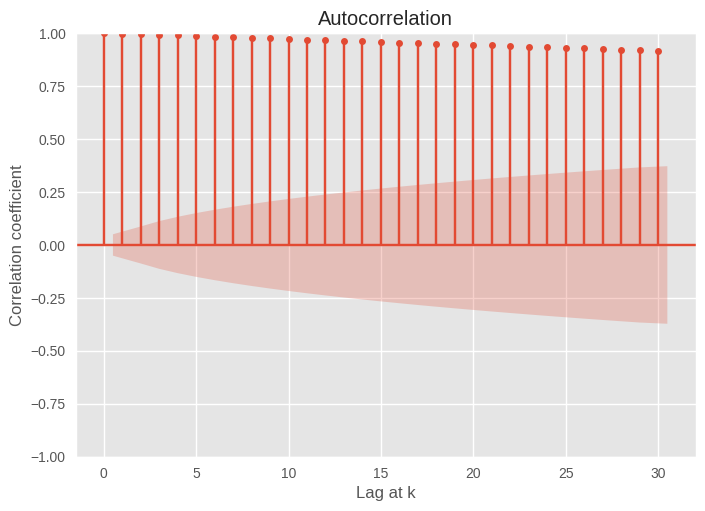

In [ ]:
numerical_data = df['Close']

plt.style.use('ggplot')
plot_acf(numerical_data, lags=30)
plt.ylabel("Correlation coefficient")
plt.xlabel('Lag at k')
plt.show()

### 3.1.2 PACF

The partial autocorrelation function of lag (k) of a series is the coefficient of that lag in the autoregression equation of Y. The autoregressive equation of Y is nothing but the linear regression of Y with its own lags as predictors.

For example, if Y_t is the current series and Y_t-1 is the lag 1 of Y, then the partial autocorrelation of lag 3 (Y_t-3) is the coefficient α3 of Y_t-3 in the following equation:

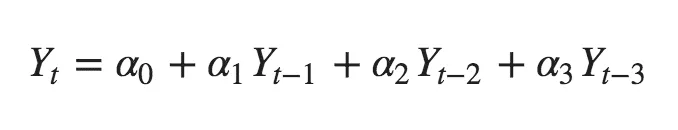

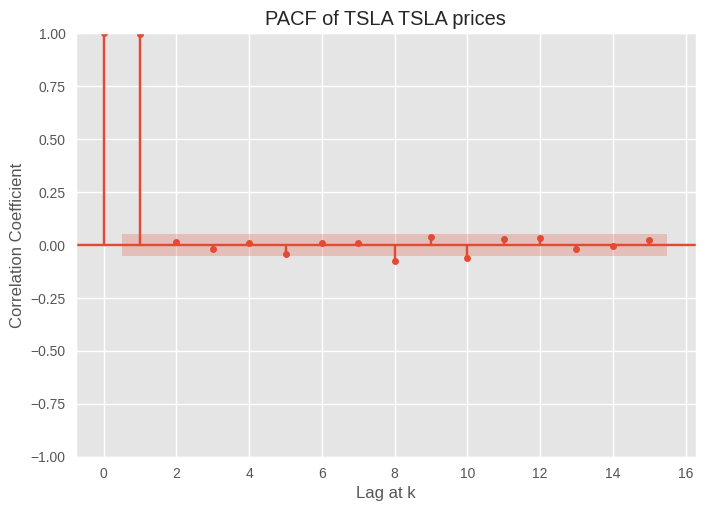

In [ ]:
# numerical_data = df['Close']

plt.style.use('ggplot')
plot_pacf(df['Close'], lags=15)
plt.title(f"PACF of TSLA {TICKER} prices")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.show()

## 3.2 Stationarity
Most of the time series are non-stationary either it gives an upward or downward trend or seasonal effect. checking the stationarity is the most important thing that we should handle if we want to make a good prediction of such time serie.

#### 3.2.1 Graphical Analysis

**1**- **Lag Plot**:
The stationarity can be checked by looking at Lag plot. A lag plot is used to checks whether the time series data is random or not, and if the data is correlated with themselves. Random data should not have any identifiable patterns, such as linear.

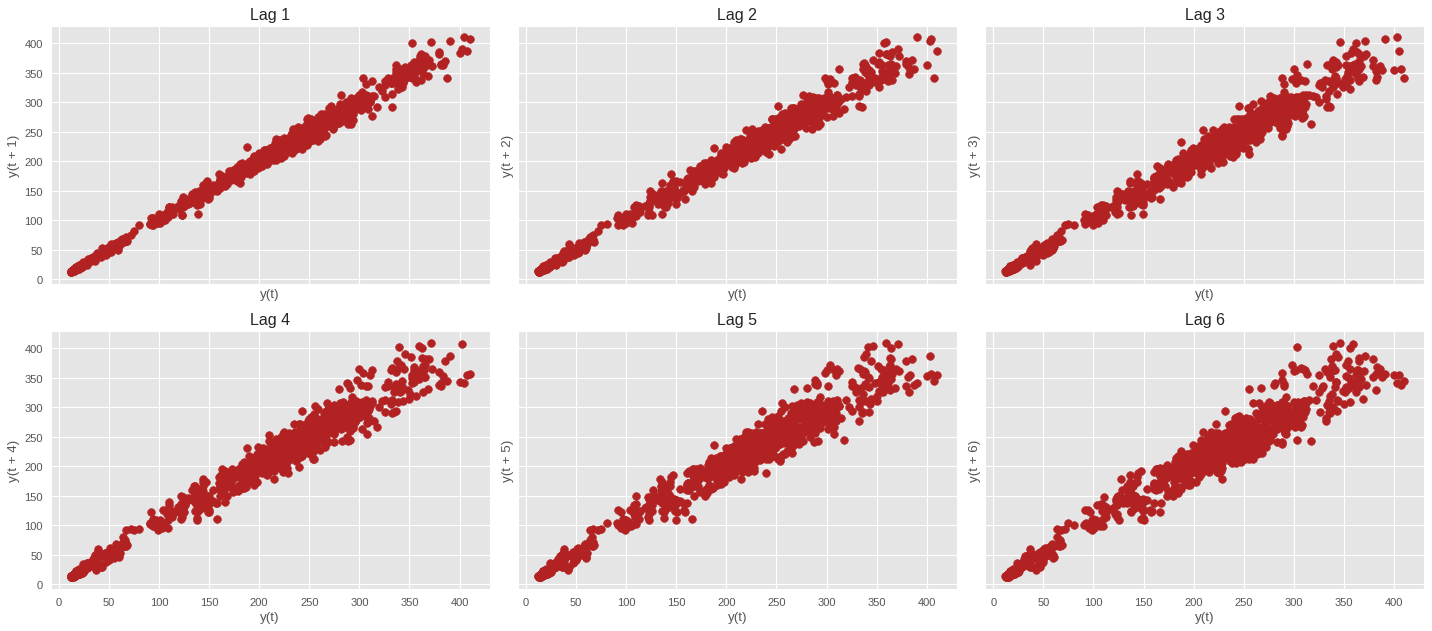

In [ ]:
# numerical_data = df['Close']

fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True, dpi=80)
for i, ax in enumerate(axes.flatten()[:6]):
    lag_plot(df['Close'], lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

plt.tight_layout()
plt.show()

**2**- **Rolling Statistic**:

we can check for stationarity by looking at how rolling average and rolling standard deviation behave in time.

In [ ]:
df

,index,Open,High,Low,Close,Adj Close,Volume,Daily_Return,Log_Return,Price_Range,...,Daily_Pct_Change,MA5,MA20,MA50,BB_middle,BB_upper,BB_lower,Volume_MA5,Price_Momentum,Volume_Ratio
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,0,20.799999,21.474001,20.733334,21.368668,21.368668,65283000,NaN,NaN,0.035609,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,1,21.400000,21.683332,21.036667,21.150000,21.150000,67822500,-0.010233,-0.010286,0.030218,...,-1.023311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,2,20.858000,21.236668,20.378668,20.974667,20.974667,149194500,-0.008290,-0.008325,0.041135,...,-0.828998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,3,21.108000,21.149332,20.799999,21.105333,21.105333,68868000,0.006230,0.006210,0.016550,...,0.622974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,4,21.066668,22.468000,21.033333,22.427334,22.427334,147891000,0.062638,0.060755,0.068101,...,6.263822,21.405200,NaN,NaN,NaN,NaN,NaN,99811800.0,NaN,1.481699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,1504,256.760010,258.220001,251.369995,252.539993,252.539993,93249800,-0.007701,-0.007731,0.026679,...,-0.770140,252.695999,244.503500,232.553000,244.503500,258.203263,230.803736,110218980.0,-0.960007,0.846041
2023-12-26,1505,254.490005,257.970001,252.910004,256.609985,256.609985,86892400,0.016116,0.015988,0.019883,...,1.611623,253.601996,245.529999,232.662800,245.529999,259.642586,231.417411,104314160.0,4.529984,0.832988
2023-12-27,1506,258.350006,263.339996,257.519989,261.440002,261.440002,106494400,0.018822,0.018647,0.022528,...,1.882241,254.445996,246.265999,232.813200,246.265999,262.073476,230.458522,104265560.0,4.220001,1.021377


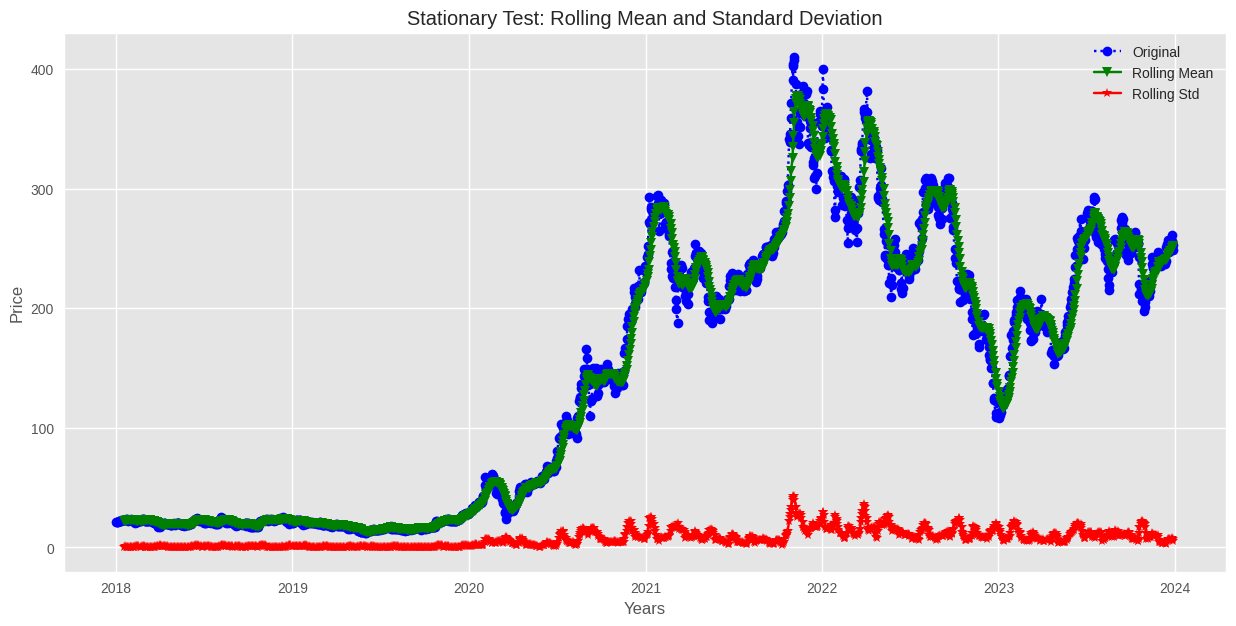

In [ ]:
# Get rolling statistics for window = 12 i.e. yearly statistics
rolling_mean =  df['Close'].rolling(window=12).mean()
rolling_std =  df['Close'].rolling(window=12).std()

# Plot rolling statistics
plt.figure(figsize=(15, 7))
plt.xlabel('Years')
plt.ylabel('Price')
plt.title('Stationary Test: Rolling Mean and Standard Deviation')
plt.plot(df.index,  df['Close'], 'b:', marker='o', label='Original')
plt.plot(df.index, rolling_mean, 'g-', marker='v', label='Rolling Mean')
plt.plot(df.index, rolling_std, 'r-', marker='*', label='Rolling Std')
plt.legend()
plt.show()

## 3.3 Augmented Dickey Fuller test (ADF Test):
Augmented Dickey Fuller test or (ADF Test) is the most commonly used test to detect stationarity. Here, we assume that the null hypothesis is the time series possesses a unit root and is non-stationary. Then, we collect evidence to support or reject the null hypothesis. So, if we find that the p-value in ADF test is less than the significance level (0.05), we reject the null hypothesis.

ADF tests the null hypothesis that a unit root is present in time series sample. ADF statistic is a negative number and more negative it is the stronger the rejection of the hypothesis that there is a unit root.

> * Null Hypothesis (H0): If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
> * Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary.
> * p-value > 0.05: Accept H0, the data has a unit root and is non-stationary
> * p-value ≤ 0.05: Reject H0. the data does not have a unit root and is stationary
> * Test statistics: More negative this value more likely we have stationary series. Also, this value should be smaller than critical values(1%, 5%, 10%). For e.g. If test statistic is smaller than the 5% critical values, then we can say with 95% confidence that this is a stationary series.

In [ ]:
def stationarity_test(time_series):
    # Ensure input is a Series and has no missing values
    time_series = time_series.dropna()

    # Plot the original time series
    plt.figure(figsize=(14, 6))
    plt.subplot(211)
    plt.plot(time_series, label='Original Series', color='blue')
    plt.title('Original Time Series')
    plt.grid(True)

    # Calculate first differences
    first_diff = time_series.diff().dropna()

    # Plot the first differenced series
    plt.subplot(212)
    plt.plot(first_diff, label='First Differences', color='orange')
    plt.title('First Differenced Series')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Perform ADF test on the first differenced series
    df_test = adfuller(first_diff)

    # Create a DataFrame to display the ADF statistic and p-value
    adf_results_df = pd.DataFrame({
        'Metric': ['ADF Statistic', 'p-value'],
        'Value': [df_test[0], df_test[1]]
    })

    # Create a DataFrame to display the critical values
    critical_values_df = pd.DataFrame(df_test[4], index=['Critical Values']).T

    return adf_results_df, critical_values_df


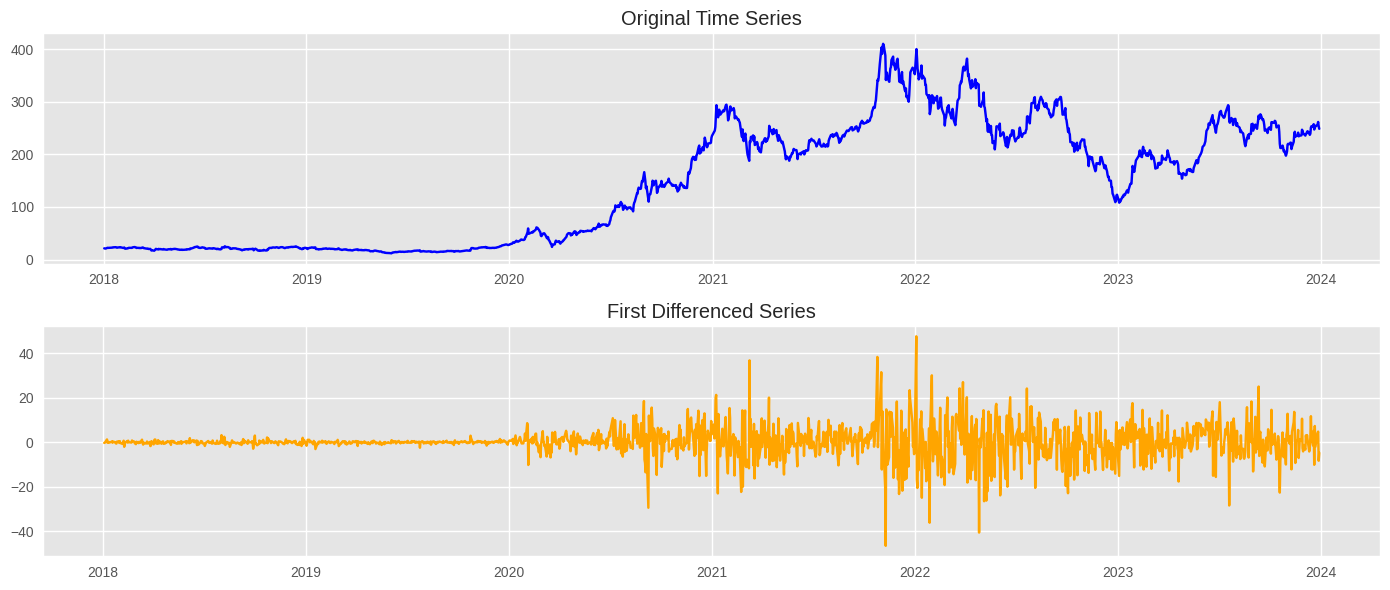

In [ ]:
# Lets test the stationarity
adf_results, critical_values = stationarity_test(df['Close'])

In [ ]:
adf_results

,Metric,Value
0,ADF Statistic,-7.352158e+00
1,p-value,9.994273e-11


In [ ]:
critical_values

,Critical Values
1%,-3.434764
5%,-2.863490
10%,-2.567808


**As** we see the test statistic is way above any critica values and the p-value also way above 0.05. then the time serie has an unit root and is non-stationary.

There is many sort of transformations to make the time series stationary for make it able to be modeled.

In [ ]:
def stationarity_test_with_lags(time_series, max_lags):
    # Ensure input is a Series and has no missing values
    time_series = time_series.dropna()

    # Calculate first differences
    first_diff = time_series.diff().dropna()

    # Prepare a DataFrame to collect ADF test results for different lags
    results = []

    for lag in range(1, max_lags + 1):
        # Perform ADF test on the first differenced series with the current lag
        df_test = adfuller(first_diff, maxlag=lag)

        # Store the results in a dictionary
        result_dict = {
            'Lag': lag,
            'ADF Statistic': df_test[0],
            'P-value': df_test[1],
            # 'Critical Value 1%': df_test[4]['1%'],
            # 'Critical Value 5%': df_test[4]['5%'],
            # 'Critical Value 10%': df_test[4]['10%']
        }
        results.append(result_dict)

    # Convert the list of results to a DataFrame
    results_df = pd.DataFrame(results)

    # Print the results DataFrame without displaying the index
    # print()
    results_df.to_string(index=False)

    return results_df

# Perform the stationarity test with different lags, specifying a maximum number of lags (e.g., 10)
adf_results_with_lags = stationarity_test_with_lags(df['Close'], max_lags=10)
adf_results_with_lags

,Lag,ADF Statistic,P-value
0,1,-39.998413,0.000000e+00
1,2,-39.998413,0.000000e+00
2,3,-18.351301,2.236265e-30
3,4,-18.351301,2.236265e-30
4,5,-18.351301,2.236265e-30
5,6,-13.139430,1.439546e-24
6,7,-13.008193,2.600991e-24
7,8,-11.354494,9.810357e-21
8,9,-11.332559,1.103560e-20
9,10,-11.332559,1.103560e-20


### 3.3.1 Differencing:
To transform the series using 'Differencing' we will use the diff() method of pandas.

In [ ]:
def plot_differenced_data(df):
    # Ensure 'Close' column is numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

    # Drop rows with NaN values that may result from conversion
    df = df.dropna(subset=['Close'])

    # First order differencing
    df_tsla_stock = df[['Close']].diff(1).bfill()

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df_tsla_stock['Close'], 'b-.')
    plt.xlabel('Date')
    plt.ylabel('Differenced Price')
    plt.title('Convert Non-Stationary Data to Stationary Data Using Differencing')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

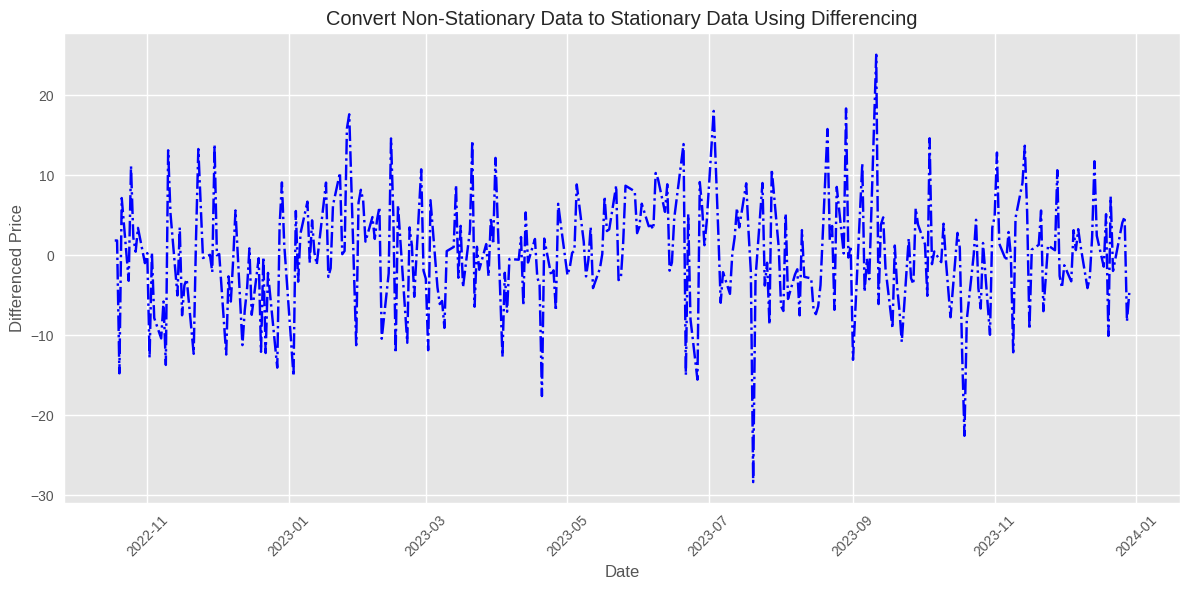

In [ ]:
plot_differenced_data(test)

In [ ]:
def plot_charts(df):

    # Create a 2x2 grid for subplots
    fig, axs = plt.subplots(2, 2, figsize=(30, 15))

    # Plot the distribution of the 'Close' prices
    sns.histplot(df['Close'], bins=50, kde=True, color='royalblue', ax=axs[0, 0])
    axs[0, 0].set_title('Distribution of Close Prices')
    axs[0, 0].set_xlabel('Close Price')
    axs[0, 0].set_ylabel('Frequency')

    # Plot the time series of the 'Close' prices
    df['Close'].plot(ax=axs[0, 1], color='royalblue', legend=True)
    axs[0, 1].set_title('Time Series of Close Prices')
    axs[0, 1].set_xlabel('Date')
    axs[0, 1].set_ylabel('Close Price')
    axs[0, 1].legend(['Close'], loc='upper left')

    # Plot the correlation matrix
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, ax=axs[1, 0])
    axs[1, 0].set_title('Correlation Matrix')

    # Plot the histogram of closing prices with date
    df.reset_index()['Date'].map(lambda x: x.year).hist(bins=50, color='royalblue', edgecolor='black', ax=axs[1, 1])
    axs[1, 1].set_title('Histogram of Closing Prices with Date')
    axs[1, 1].set_xlabel('Date')
    axs[1, 1].set_ylabel('Frequency')
    axs[1, 1].grid(True)

    # Adjust layout
    plt.tight_layout()
    return plt.show()

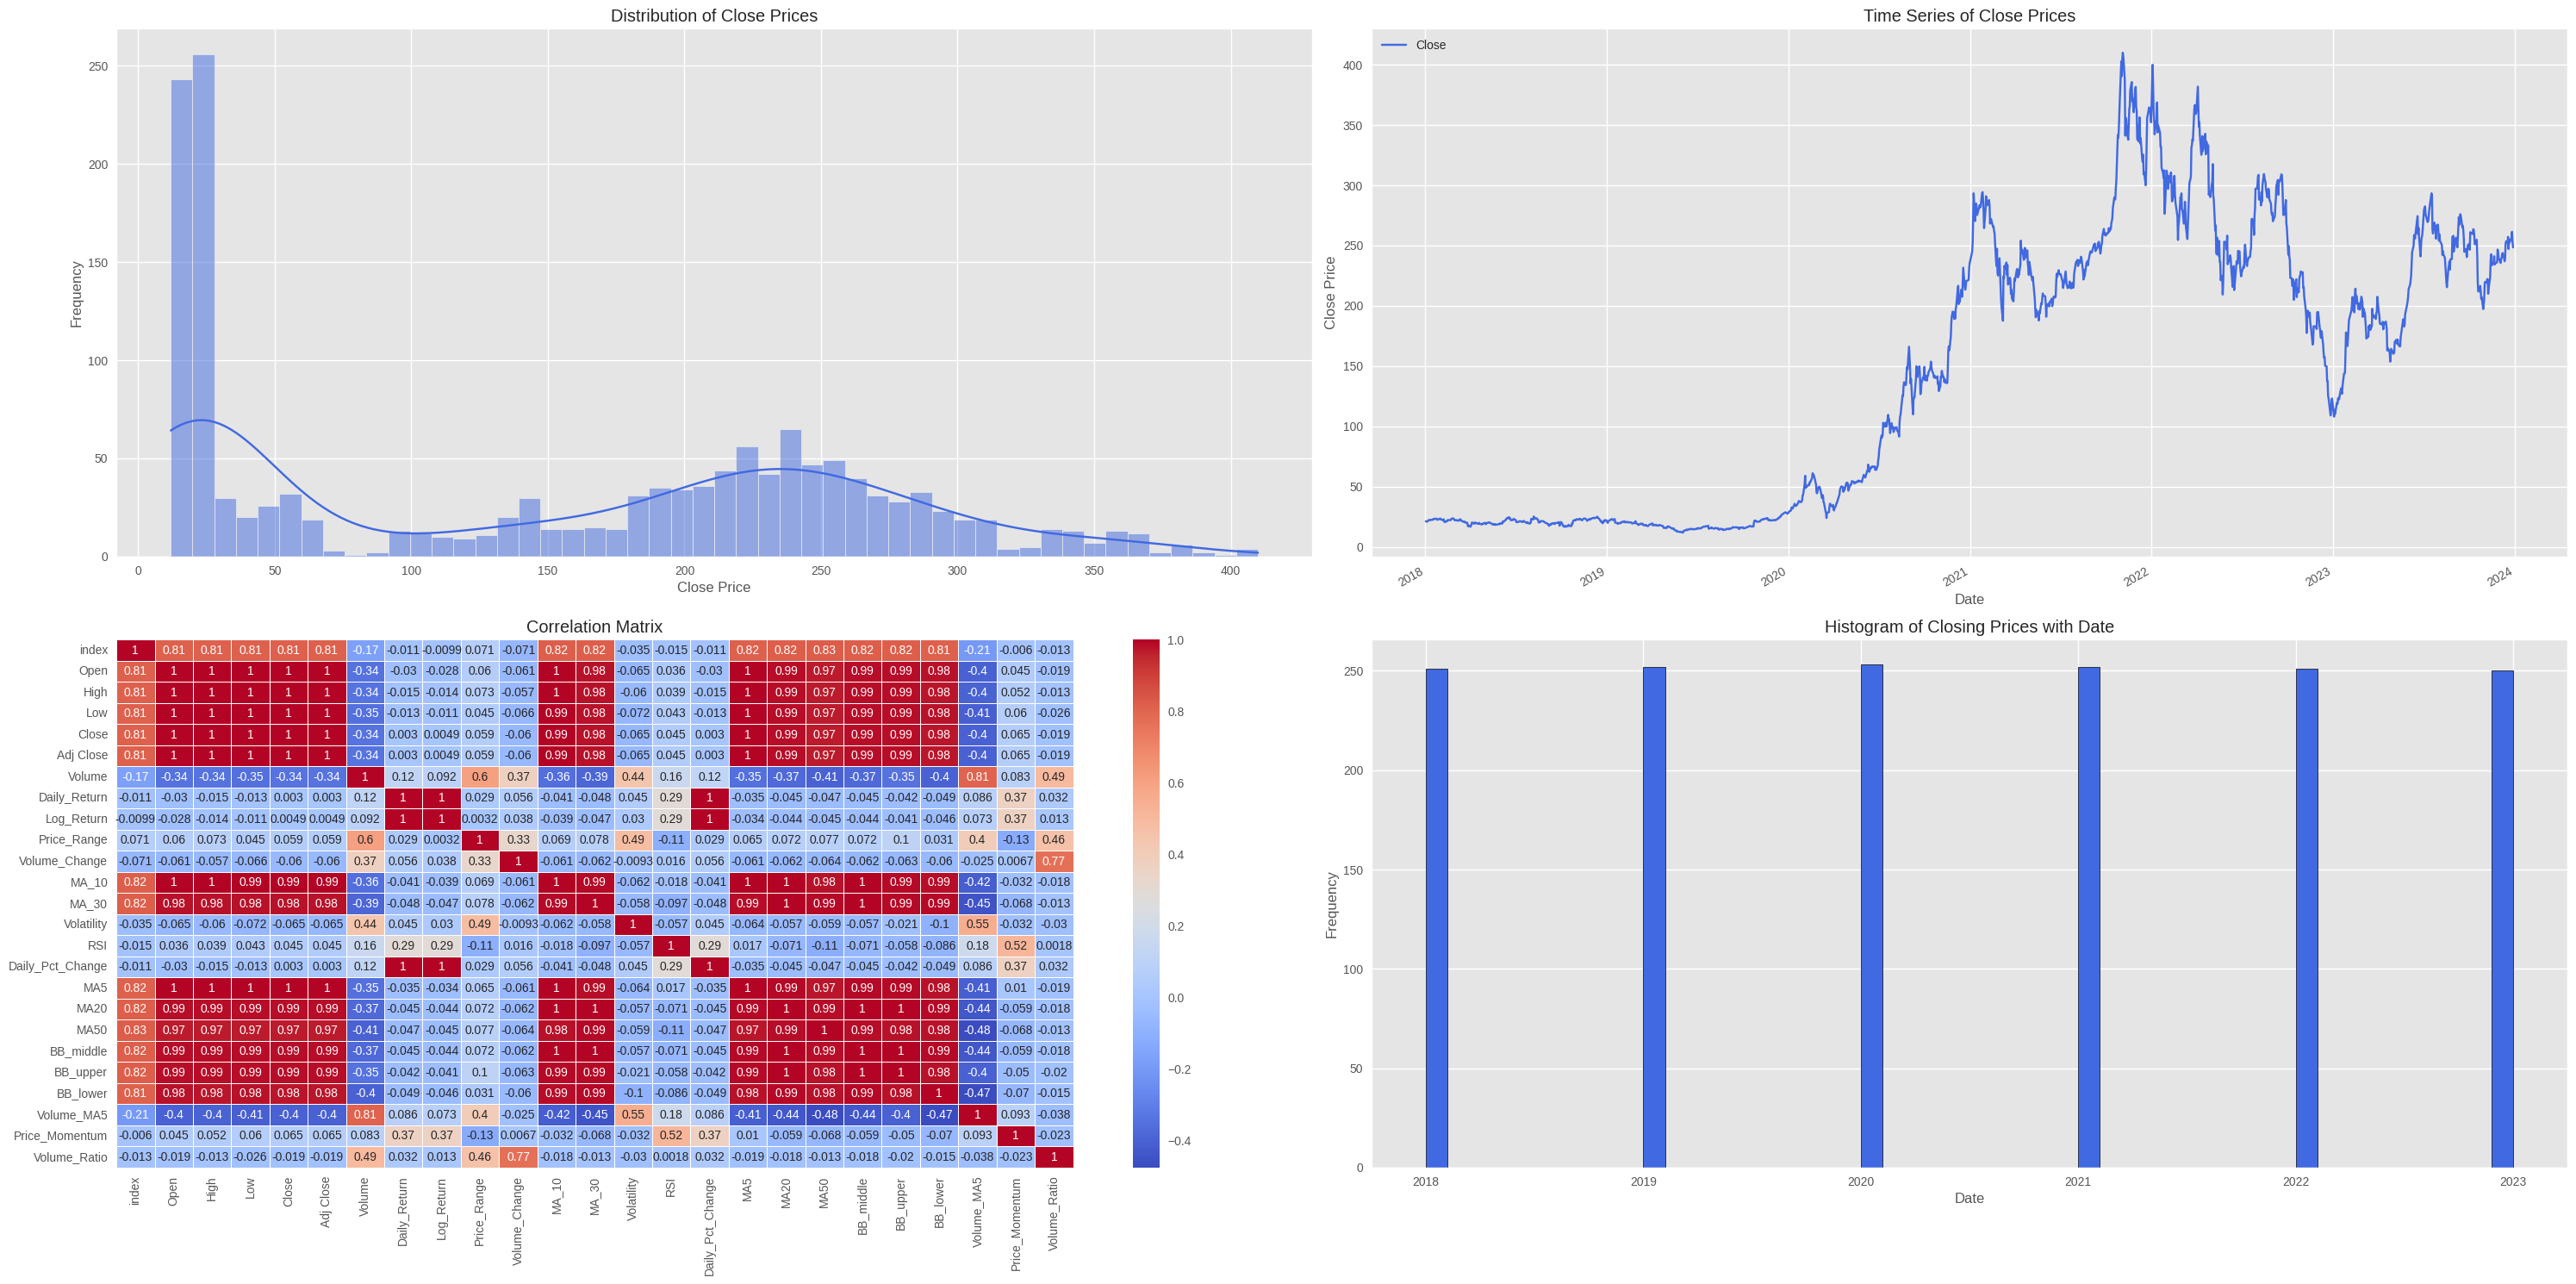

In [ ]:
plot_charts(df)

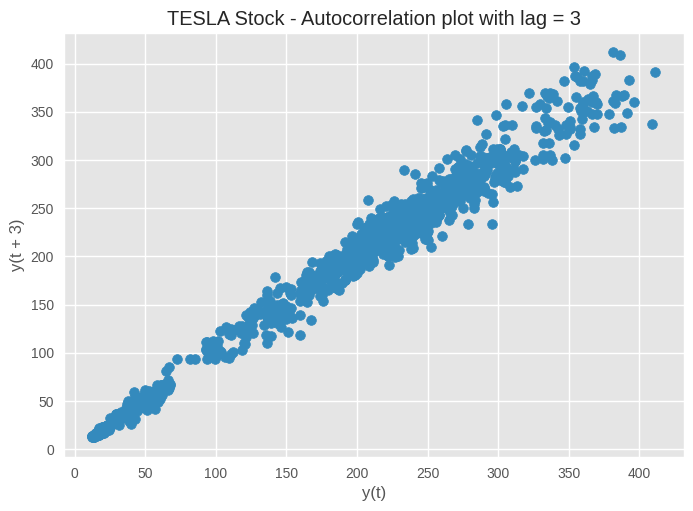

In [ ]:
plt.figure()
lag_plot(df['Open'], lag=3)
plt.title('TESLA Stock - Autocorrelation plot with lag = 3')
plt.show()

# 4. Autoregressive Integrated Moving Average (ARIMA)


## 4.1 Autoregressive Integrated Moving Average (ARIMA)

In [ ]:
class ArimaModel:
    def __init__(self, train, test, target_column):
        """
        Initializes the ARIMAModel with training and testing datasets.

        Parameters:
        train (pd.DataFrame): The training dataset.
        test (pd.DataFrame): The testing dataset.
        target_column (str): The name of the column to use for ARIMA modeling.
        """
        # Ensure the target column exists
        if target_column not in train.columns or target_column not in test.columns:
            raise ValueError(f"Column '{target_column}' not found in the dataframes.")

        self.target_column = target_column

        # Extract the target column as a Series and ensure data is numeric and clean
        self.train = pd.to_numeric(train[target_column], errors='coerce').dropna()
        self.test = pd.to_numeric(test[target_column], errors='coerce').dropna()

        # If necessary, convert the index to datetime
        if not isinstance(self.train.index, pd.DatetimeIndex):
            self.train.index = pd.to_datetime(self.train.index)
        if not isinstance(self.test.index, pd.DatetimeIndex):
            self.test.index = pd.to_datetime(self.test.index)

        self.best_order = None
        self.best_rmse = float("inf")
        self.best_model = None
        self.forecast = None
        self.results_df = pd.DataFrame(columns=[
            'Order', 'MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE',
            'R_Squared', 'Adj_R_Squared', 'AIC', 'BIC'
        ])

    @staticmethod
    def mean_absolute_scaled_error(y_true, y_pred):
        """
        Calculates Mean Absolute Scaled Error (MASE).
        """
        n = len(y_true)
        d = np.abs(np.diff(y_true)).sum() / (n - 1)
        return np.abs(y_true - y_pred).mean() / d if d != 0 else float('inf')  # Avoid division by zero

    @staticmethod
    def symmetric_mean_absolute_percentage_error(y_true, y_pred):
        """
        Calculates Symmetric Mean Absolute Percentage Error (SMAPE).
        """
        return 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + np.finfo(float).eps))  # Avoid division by zero

    @staticmethod
    def adjusted_r_squared(r_squared, n, p):
        """
        Calculates Adjusted R-Squared.
        """
        return 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

    def evaluate_model(self, model, order):
        """
        Fits the model, makes forecasts, and evaluates performance metrics.
        """
        try:
            results = model.fit()
            forecast = results.forecast(steps=len(self.test))
            mse = mean_squared_error(self.test, forecast)
            mae = mean_absolute_error(self.test, forecast)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((self.test - forecast) / self.test)) * 100 if not np.all(self.test == 0) else float('inf')  # Avoid division by zero
            smape = self.symmetric_mean_absolute_percentage_error(self.test, forecast)
            mase = self.mean_absolute_scaled_error(self.test, forecast)
            r_squared = r2_score(self.test, forecast)
            adj_r_squared = self.adjusted_r_squared(r_squared, len(self.test), len(order))
            aic_value = results.aic
            bic_value = results.bic

            return {
                'Order': order,
                'MSE': mse,
                'MAE': mae,
                'RMSE': rmse,
                'MAPE': mape,
                'SMAPE': smape,
                'MASE': mase,
                'R_Squared': r_squared,
                'Adj_R_Squared': adj_r_squared,
                'AIC': aic_value,
                'BIC': bic_value
            }
        except Exception as e:
            print(f"Error evaluating model with order {order}: {e}")
            return None

    def grid_search(self):
        """
        Performs a grid search to find the most optimal ARIMA model order based on the lowest MSE.
        """
        p = d = q = range(0, 6)
        pdq = list(itertools.product(p, d, q))
        results = []

        for param in pdq:
            try:
                p, d, q = param  # Unpack the current order
                model = ARIMA(self.train, order=param)
                evaluation = self.evaluate_model(model, param)
                if evaluation:
                    mse = evaluation['MSE']
                    print(f'ARIMA(p={p}, d={d}, q={q}) MSE: {mse:.4f}')  # Display the ARIMA order and MSE

                    results.append(evaluation)
                    if mse < self.best_rmse:
                        self.best_rmse = mse
                        self.best_order = param
                        self.best_model = model
            except Exception as e:
                print(f"Error evaluating model with order (p={p}, d={d}, q={q}): {e}")

        if results:
            self.results_df = pd.DataFrame(results)
            print(f"Best order found: {self.best_order} with MSE: {self.best_rmse:.4f}")
        else:
            print("No optimal order found.")


    def fit_best_model(self):
        """
        Fits the best ARIMA model found during grid search.
        """
        if self.best_order is None:
            raise ValueError("Best order not found. Please run grid_search first.")
        self.best_model = ARIMA(self.train, order=self.best_order)
        self.best_model = self.best_model.fit()

    def make_forecast(self):
        """
        Makes forecast using the best fitted ARIMA model.
        """
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")
        self.forecast = self.best_model.forecast(steps=len(self.test))

    def plot_results(self):
        """
        Plots the training data, validation data, and forecasted values, and indicates the ARIMA (p, d, q) values.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")

        p, d, q = self.best_order  # Extract the p, d, q values

        plt.figure(figsize=(12, 6))
        plt.plot(self.train.index, self.train, label='Training Data')
        plt.plot(self.test.index, self.test, label='Validation Data')
        plt.plot(self.test.index, self.forecast, label='Forecast')
        plt.legend()

        # Title with ARIMA order
        plt.title(f'Stock Price Forecast (ARIMA Order: (p={p}, d={d}, q={q}))')

        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.gcf().autofmt_xdate()  # Ensure the dates on the x-axis are formatted correctly

        # Add text to indicate the p, d, q values on the plot
        plt.text(0.05, 0.95, f'ARIMA Order: (p={p}, d={d}, q={q})', transform=plt.gca().transAxes,
                fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        plt.tight_layout()
        plt.show()


    def plot_accuracy(self):
        """
        Plots the accuracy of the forecast by comparing predicted vs actual values.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        plt.figure(figsize=(12, 6))
        plt.plot(self.test.index, self.test, label='Actual Data', color='green')
        plt.plot(self.test.index, self.forecast, label='Forecasted Data', color='red')
        plt.fill_between(self.test.index, self.test, self.forecast, color='grey', alpha=0.2)
        plt.legend()
        plt.title(f'Accuracy of ARIMA Forecast (Order: {self.best_order})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.gcf().autofmt_xdate()  # Ensure the dates on the x-axis are formatted correctly
        plt.tight_layout()
        plt.show()

    def print_evaluation_metrics(self):
        """
        Prints the evaluation metrics for the forecast.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        mse = mean_squared_error(self.test, self.forecast)
        mae = mean_absolute_error(self.test, self.forecast)
        rmse = np.sqrt(mse)
        print(f"Final Mean Squared Error: {mse}")
        print(f"Final Mean Absolute Error: {mae}")
        print(f"Final Root Mean Squared Error: {rmse}")

    def print_model_summary(self):
        """
        Prints the model summary and the parameters used.
        If 'SARIMAX' is found in the model summary, it is replaced with 'ARIMA'.
        """
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")

        # Get the original summary
        original_summary = self.best_model.summary().as_text()

        # Replace 'SARIMAX' with 'ARIMA' in the summary
        modified_summary = original_summary.replace("SARIMAX", "ARIMA")

        # Print the modified summary
        print(modified_summary)

        # Extract and print coefficients
        print("Model Coefficients:")
        for param_name, value in zip(self.best_model.model.param_names, self.best_model.params):
            print(f"{param_name}: {value:.4f}")

    def display_top_orders(self, top_n=5):
        """
        Displays the top N ARIMA model orders with the lowest MSE along with their evaluation metrics.

        Parameters:
        top_n (int): The number of top models to display.
        """
        if self.results_df.empty:
            raise ValueError("No results available. Please run grid_search first.")

        # Sort by MSE and select top N rows
        top_results = self.results_df.sort_values(by='MSE').head(top_n)

        # Display the top results DataFrame
        print(f"Top {top_n} ARIMA model orders with the lowest MSE:")
        # display(top_results)

        return top_results

    def get_best_order(self):
        """
        Returns the best order found during grid search.
        """
        if self.best_order is None:
            raise ValueError("Best order not found. Please run grid_search first.")
        return self.best_order

    def get_forecast(self):
        """
        Returns the forecast made by the best fitted ARIMA model.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        return self.forecast

    def plot_acf_pacf(self, lags=40):
        """
        Plots the ACF and PACF of the training data.

        Parameters:
        lags (int): Number of lags to include in the plots.
        """
        plt.figure(figsize=(14, 7))

        plt.subplot(121)
        plot_acf(self.train, lags=lags, ax=plt.gca())
        plt.title('Autocorrelation Function (ACF)')

        plt.subplot(122)
        plot_pacf(self.train, lags=lags, ax=plt.gca())
        plt.title('Partial Autocorrelation Function (PACF)')

        plt.tight_layout()
        plt.show()

    def plot_acf_pacf(self, lags=40):
        """
        Plots the ACF and PACF of the training data.

        Parameters:
        lags (int): Number of lags to include in the plots.
        """
        plt.figure(figsize=(14, 7))

        plt.subplot(121)
        plot_acf(self.train, lags=lags, ax=plt.gca())
        plt.title('Autocorrelation Function (ACF)')

        plt.subplot(122)
        plot_pacf(self.train, lags=lags, ax=plt.gca())
        plt.title('Partial Autocorrelation Function (PACF)')

        plt.tight_layout()
        plt.show()

In [ ]:
train.dtypes

,0
index,int64
Open,float64
High,float64
Low,float64
Close,float64
Adj Close,float64
Volume,int64


In [ ]:
arima_model = ArimaModel(train, test, target_column='Close')

In [ ]:
# Perform grid search
arima_model.grid_search()

ARIMA(p=0, d=0, q=0) MSE: 8460.3811
ARIMA(p=0, d=0, q=1) MSE: 8435.7317
ARIMA(p=0, d=0, q=2) MSE: 8434.2531
ARIMA(p=0, d=0, q=3) MSE: 8445.3089
ARIMA(p=0, d=0, q=4) MSE: 8388.6366
ARIMA(p=0, d=0, q=5) MSE: 8394.9711
ARIMA(p=0, d=1, q=0) MSE: 1891.7027
ARIMA(p=0, d=1, q=1) MSE: 1890.7273
ARIMA(p=0, d=1, q=2) MSE: 1893.5208
ARIMA(p=0, d=1, q=3) MSE: 1893.4009
ARIMA(p=0, d=1, q=4) MSE: 1896.5997
ARIMA(p=0, d=1, q=5) MSE: 1896.7544
ARIMA(p=0, d=2, q=0) MSE: 21583.6850
ARIMA(p=0, d=2, q=1) MSE: 2354.2554
ARIMA(p=0, d=2, q=2) MSE: 2312.6537
ARIMA(p=0, d=2, q=3) MSE: 2359.8098
ARIMA(p=0, d=2, q=4) MSE: 2361.9816
ARIMA(p=0, d=2, q=5) MSE: 2374.0272
ARIMA(p=0, d=3, q=0) MSE: 77217149814.1522
ARIMA(p=0, d=3, q=1) MSE: 26641.6304
ARIMA(p=0, d=3, q=2) MSE: 117045.9783
ARIMA(p=0, d=3, q=3) MSE: 92803.8784
ARIMA(p=0, d=3, q=4) MSE: 38671.2237
ARIMA(p=0, d=3, q=5) MSE: 24067.1406
ARIMA(p=0, d=4, q=0) MSE: 6245450434561344.0000
ARIMA(p=0, d=4, q=1) MSE: 88727996552.2843
ARIMA(p=0, d=4, q=2) MSE: 13942

In [ ]:
# Fit the best model (0,1,1) - corresponds to simple exponential smoothing
arima_model.fit_best_model()

In [ ]:
# Make forecast and plot results
arima_model.make_forecast()

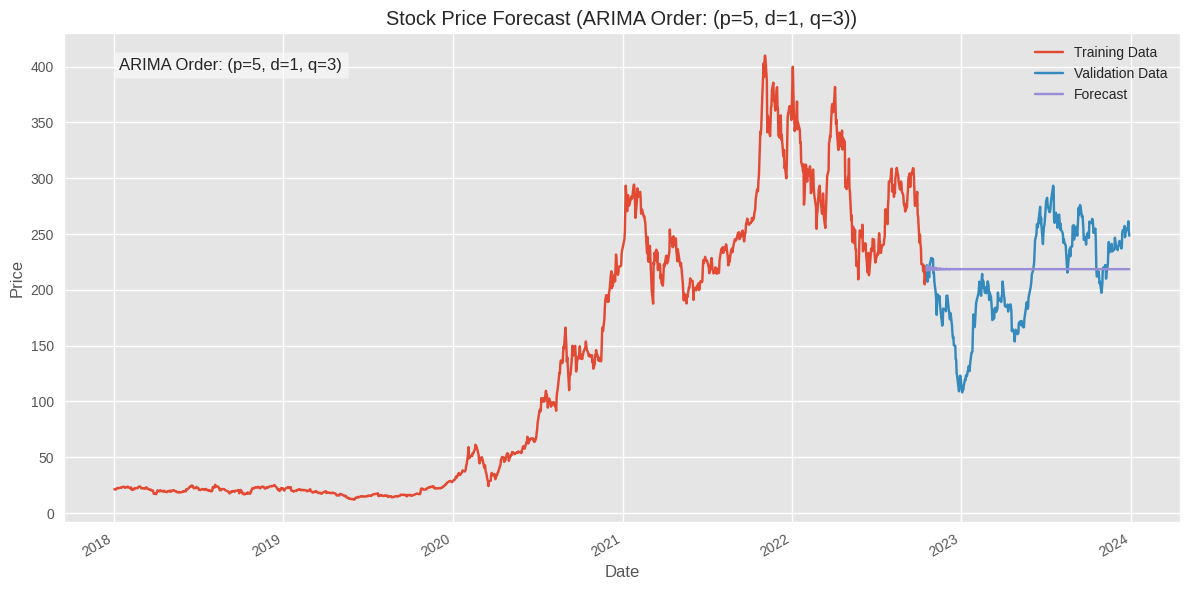

In [ ]:
arima_model.plot_results()

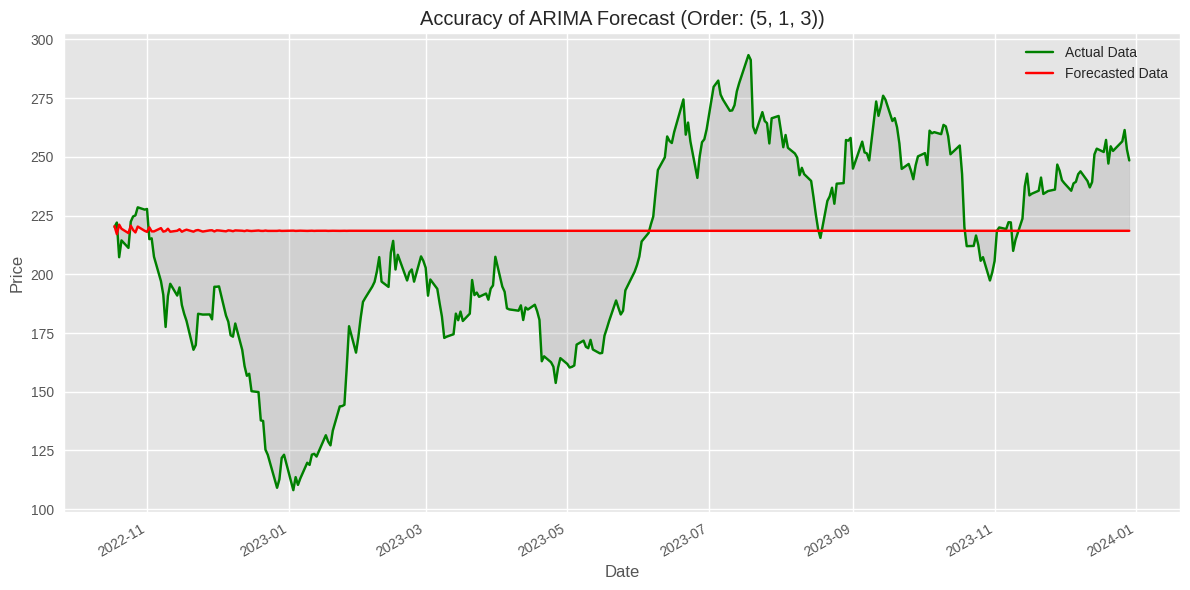

In [ ]:
arima_model.plot_accuracy()

In [ ]:
# Print evaluation metrics and model summary
arima_model.print_evaluation_metrics()

Final Mean Squared Error: 1865.3657832883282
Final Mean Absolute Error: 36.27389479192665
Final Root Mean Squared Error: 43.18988056580301


In [ ]:
arima_model.print_model_summary()

                               ARIMA Results                                
Dep. Variable:                  Close   No. Observations:                 1208
Model:                 ARIMA(5, 1, 3)   Log Likelihood               -4034.799
Date:                Thu, 22 Aug 2024   AIC                           8087.599
Time:                        22:02:32   BIC                           8133.462
Sample:                             0   HQIC                          8104.870
                               - 1208                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2614      0.406     -0.644      0.519      -1.057       0.534
ar.L2          0.0958      0.458      0.209      0.834      -0.801       0.993
ar.L3          0.7889      0.363      2.173      0.030

In [ ]:
# Display the top 5 model orders
arima_model.display_top_orders()

Top 5 ARIMA model orders with the lowest MSE:


,Order,MSE,MAE,RMSE,MAPE,SMAPE,MASE,R_Squared,Adj_R_Squared,AIC,BIC
189,"(5, 1, 3)",1865.365783,36.273895,43.189881,NaN,NaN,NaN,-0.029467,-0.039830,8087.598915,8133.461954
116,"(3, 1, 2)",1874.952577,36.321536,43.300723,NaN,NaN,NaN,-0.034757,-0.045174,8085.646122,8116.221481
153,"(4, 1, 3)",1881.045326,36.357476,43.371019,NaN,NaN,NaN,-0.038120,-0.048571,8086.443158,8127.210303
79,"(2, 1, 1)",1882.376260,36.357763,43.386360,NaN,NaN,NaN,-0.038854,-0.049313,8107.309870,8127.693443
115,"(3, 1, 1)",1882.471716,36.358725,43.387460,NaN,NaN,NaN,-0.038907,-0.049366,8109.261926,8134.741392


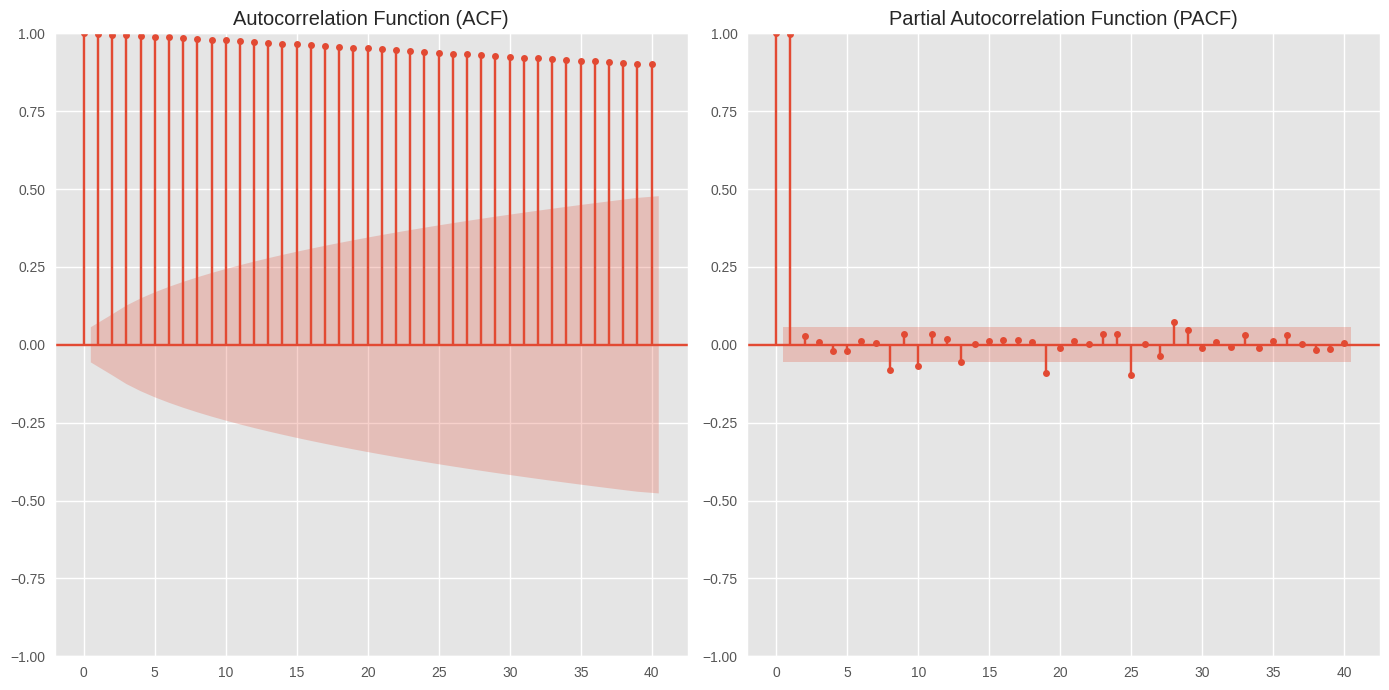

In [ ]:
arima_model.plot_acf_pacf()

## 4.2 ARIMAX (AutoRegressive Integrated Moving Average with eXogenous variables)


In [ ]:
class ARIMAXModel:
    def __init__(self, train, test, target_column, exog_vars):
        """
        Initializes the ARIMAXModel with training and testing datasets.

        Parameters:
        train (pd.DataFrame): The training dataset.
        test (pd.DataFrame): The testing dataset.
        target_column (str): The name of the column to use for ARIMAX modeling.
        exog_vars (list): List of exogenous variables to use in the model.
        """
        if target_column not in train.columns or target_column not in test.columns:
            raise ValueError(f"Column '{target_column}' not found in the dataframes.")

        self.target_column = target_column
        self.exog_vars = exog_vars

        # Extract the target column as a Series and ensure data is numeric and clean
        self.train = pd.to_numeric(train[target_column], errors='coerce').dropna()
        self.test = pd.to_numeric(test[target_column], errors='coerce').dropna()
        self.train_exog = train[exog_vars]
        self.test_exog = test[exog_vars]

        if not isinstance(self.train.index, pd.DatetimeIndex):
            self.train.index = pd.to_datetime(self.train.index)
        if not isinstance(self.test.index, pd.DatetimeIndex):
            self.test.index = pd.to_datetime(self.test.index)

        self.best_order = None
        self.best_rmse = float("inf")
        self.best_model = None
        self.forecast = None
        self.results_df = pd.DataFrame(columns=[
            'Order', 'MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE',
            'R_Squared', 'Adj_R_Squared', 'AIC', 'BIC'
        ])

    @staticmethod
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        non_zero_mask = y_true != 0
        return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

    @staticmethod
    def symmetric_mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        denominator = (np.abs(y_true) + np.abs(y_pred) + np.finfo(float).eps)
        return 100 * np.mean(2 * np.abs(y_true - y_pred) / denominator)

    @staticmethod
    def mean_absolute_scaled_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        n = len(y_true)
        d = np.abs(np.diff(y_true)).sum() / (n - 1)
        if d == 0:
            return float('inf')  # Returning infinity if naive forecast method is not valid
        return np.abs(y_true - y_pred).mean() / d

    @staticmethod
    def adjusted_r_squared(r_squared, n, p):
        """
        Calculates Adjusted R-Squared.
        """
        return 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

    def evaluate_model(self, model, order):
        """
        Fits the model, makes forecasts, and evaluates performance metrics.
        """
        try:
            results = model.fit()
            forecast = results.forecast(steps=len(self.test), exog=self.test_exog)
            mse = mean_squared_error(self.test, forecast)
            mae = mean_absolute_error(self.test, forecast)
            rmse = np.sqrt(mse)
            mape = self.mean_absolute_percentage_error(self.test, forecast)
            smape = self.symmetric_mean_absolute_percentage_error(self.test, forecast)
            mase = self.mean_absolute_scaled_error(self.test, forecast)
            r_squared = r2_score(self.test, forecast)
            adj_r_squared = self.adjusted_r_squared(r_squared, len(self.test), len(order))
            aic_value = results.aic
            bic_value = results.bic

            return {
                'Order': order,
                'MSE': mse,
                'MAE': mae,
                'RMSE': rmse,
                'MAPE': mape,
                'SMAPE': smape,
                'MASE': mase,
                'R_Squared': r_squared,
                'Adj_R_Squared': adj_r_squared,
                'AIC': aic_value,
                'BIC': bic_value
            }
        except Exception as e:
            print(f"Error evaluating model with order {order}: {e}")
            return None

    def grid_search(self):
        """
        Performs a grid search to find the most optimal ARIMAX model order based on the lowest MSE.
        """
        p = d = q = range(0, 6)
        pdq = list(itertools.product(p, d, q))
        results = []

        for param in pdq:
            try:
                p, d, q = param  # Unpack the current order
                model = ARIMA(self.train, exog=self.train_exog, order=param)
                evaluation = self.evaluate_model(model, param)
                if evaluation:
                    mse = evaluation['MSE']
                    print(f'ARIMAX(p={p}, d={d}, q={q}) MSE: {mse:.4f}')

                    results.append(evaluation)
                    if mse < self.best_rmse:
                        self.best_rmse = mse
                        self.best_order = param
                        self.best_model = model
            except Exception as e:
                print(f"Error evaluating model with order (p={p}, d={d}, q={q}): {e}")

        if results:
            self.results_df = pd.DataFrame(results)
            print(f"Best order found: {self.best_order} with MSE: {self.best_rmse:.4f}")
        else:
            print("No optimal order found.")

    def fit_best_model(self):
        """
        Fits the best ARIMAX model found during grid search.
        """
        if self.best_order is None:
            raise ValueError("Best order not found. Please run grid_search first.")
        self.best_model = ARIMA(self.train, exog=self.train_exog, order=self.best_order)
        self.best_model = self.best_model.fit()

    def make_forecast(self):
        """
        Makes forecast using the best fitted ARIMAX model.
        """
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")
        self.forecast = self.best_model.forecast(steps=len(self.test), exog=self.test_exog)

    def plot_results(self):
        """
        Plots the training data, validation data, and forecasted values, and indicates the ARIMAX (p, d, q) values.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")

        p, d, q = self.best_order  # Extract the p, d, q values

        plt.figure(figsize=(12, 6))
        plt.plot(self.train.index, self.train, label='Training Data')
        plt.plot(self.test.index, self.test, label='Validation Data')
        plt.plot(self.test.index, self.forecast, label='Forecast')
        plt.legend()

        # Title with ARIMAX order
        plt.title(f'Stock Price Forecast (ARIMAX Order: (p={p}, d={d}, q={q}))')

        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.gcf().autofmt_xdate()  # Ensure the dates on the x-axis are formatted correctly

        # Add text to indicate the p, d, q values on the plot
        plt.text(0.05, 0.95, f'ARIMAX Order: (p={p}, d={d}, q={q})', transform=plt.gca().transAxes,
                fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        plt.tight_layout()
        plt.show()

    def plot_accuracy(self):
        """
        Plots the accuracy of the forecast by comparing predicted vs actual values.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        plt.figure(figsize=(12, 6))
        plt.plot(self.test.index, self.test, label='Actual Data', color='green')
        plt.plot(self.test.index, self.forecast, label='Forecasted Data', color='red')
        plt.fill_between(self.test.index, self.test, self.forecast, color='grey', alpha=0.2)
        plt.legend()
        plt.title(f'Accuracy of ARIMAX Forecast (Order: {self.best_order})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.gcf().autofmt_xdate()  # Ensure the dates on the x-axis are formatted correctly
        plt.tight_layout()
        plt.show()

    def print_evaluation_metrics(self):
        """
        Prints the evaluation metrics for the forecast.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        mse = mean_squared_error(self.test, self.forecast)
        mae = mean_absolute_error(self.test, self.forecast)
        rmse = np.sqrt(mse)
        print(f"Final Mean Squared Error: {mse}")
        print(f"Final Mean Absolute Error: {mae}")
        print(f"Final Root Mean Squared Error: {rmse}")

    def print_model_summary(self):
        """
        Prints the model summary and the parameters used.
        """
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")

        # Get the original summary
        original_summary = self.best_model.summary().as_text()

        # Replace 'SARIMAX' with 'ARIMAX' in the summary
        modified_summary = original_summary.replace("SARIMAX", "ARIMAX")

        # Print the modified summary
        print(modified_summary)

        # Extract and print coefficients
        print("Model Coefficients:")
        for param_name, value in zip(self.best_model.model.param_names, self.best_model.params):
            print(f"{param_name}: {value:.4f}")

    def display_top_orders(self, top_n=5):
        """
        Displays the top N ARIMAX model orders with the lowest MSE along with their evaluation metrics.

        Parameters:
        top_n (int): The number of top models to display.
        """
        if self.results_df.empty:
            raise ValueError("No results available. Please run grid_search first.")

        # Sort by MSE and select top N rows
        top_results = self.results_df.sort_values(by='MSE').head(top_n)

        # Display the top results DataFrame
        print(f"Top {top_n} ARIMAX model orders with the lowest MSE:")
        # display(top_results)

        return top_results

    def get_best_order(self):
        """
        Returns the best order found during grid search.
        """
        if self.best_order is None:
            raise ValueError("Best order not found. Please run grid_search first.")
        return self.best_order

    def get_forecast(self):
        """
        Returns the forecast made by the best fitted ARIMAX model.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        return self.forecast

    def plot_acf_pacf(self, lags=40):
        """
        Plots the ACF and PACF of the training data.

        Parameters:
        lags (int): Number of lags to include in the plots.
        """
        plt.figure(figsize=(14, 7))

        plt.subplot(121)
        plot_acf(self.train, lags=lags, ax=plt.gca())
        plt.title('Autocorrelation Function (ACF)')

        plt.subplot(122)
        plot_pacf(self.train, lags=lags, ax=plt.gca())
        plt.title('Partial Autocorrelation Function (PACF)')

        plt.tight_layout()
        plt.show()

In [ ]:
# Initialize the model
arimax_model = ARIMAXModel(train=train, test=test, target_column='Close', exog_vars=['Open', 'High', 'Low', 'Volume'])

In [ ]:
# Perform grid search
arimax_model.grid_search()

ARIMAX(p=0, d=0, q=0) MSE: 6.2368
ARIMAX(p=0, d=0, q=1) MSE: 6.2369
ARIMAX(p=0, d=0, q=2) MSE: 6.2369
ARIMAX(p=0, d=0, q=3) MSE: 6.2348
ARIMAX(p=0, d=0, q=4) MSE: 6.2364
ARIMAX(p=0, d=0, q=5) MSE: 6.2326
ARIMAX(p=0, d=1, q=0) MSE: 82.2444
ARIMAX(p=0, d=1, q=1) MSE: 73.8948
ARIMAX(p=0, d=1, q=2) MSE: 73.5050
ARIMAX(p=0, d=1, q=3) MSE: 74.1201
ARIMAX(p=0, d=1, q=4) MSE: 73.3568
ARIMAX(p=0, d=1, q=5) MSE: 73.3301
ARIMAX(p=0, d=2, q=0) MSE: 597884.9354
ARIMAX(p=0, d=2, q=1) MSE: 597884.9354
ARIMAX(p=0, d=2, q=2) MSE: 8080.3728
ARIMAX(p=0, d=2, q=3) MSE: 597884.9354
ARIMAX(p=0, d=2, q=4) MSE: 22042.9127
ARIMAX(p=0, d=2, q=5) MSE: 597884.9354
ARIMAX(p=0, d=3, q=0) MSE: 461272884.8138
ARIMAX(p=0, d=3, q=1) MSE: 461272884.8138
ARIMAX(p=0, d=3, q=2) MSE: 943313160.2581
ARIMAX(p=0, d=3, q=3) MSE: 461272884.8138
ARIMAX(p=0, d=3, q=4) MSE: 461272884.8138
ARIMAX(p=0, d=3, q=5) MSE: 461272884.8138
ARIMAX(p=0, d=4, q=0) MSE: 248466856043732.7188
ARIMAX(p=0, d=4, q=1) MSE: 248466856043728.0625
ARIMAX(

In [ ]:
# Fit the best model
arimax_model.fit_best_model()

In [ ]:
# Make the forecast
arimax_model.make_forecast()

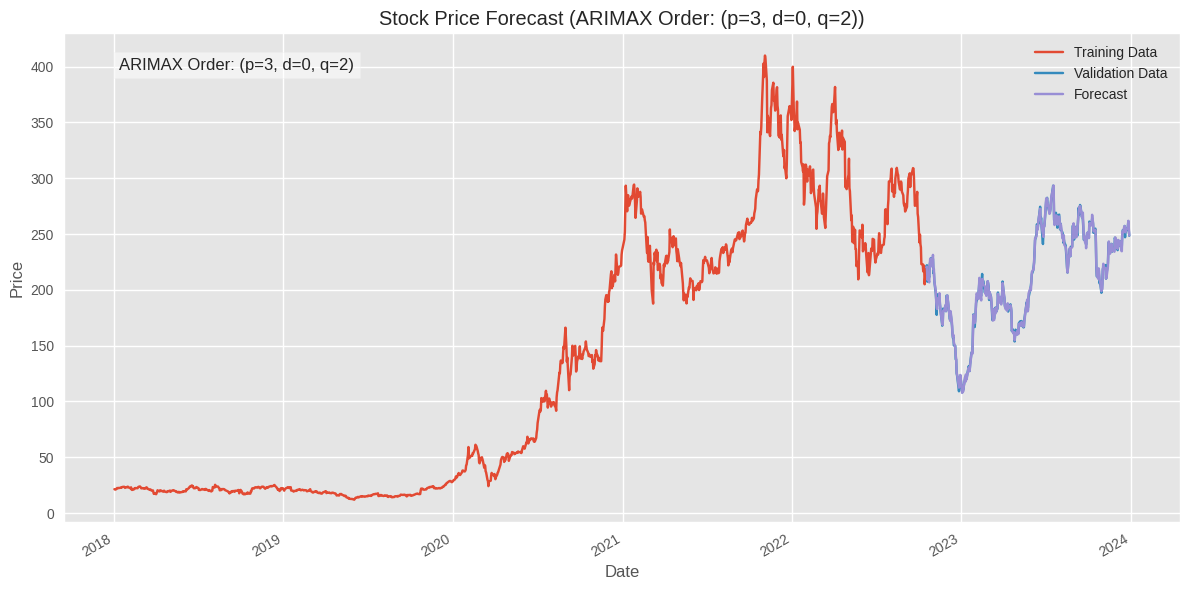

In [ ]:
# Plot the results
arimax_model.plot_results()

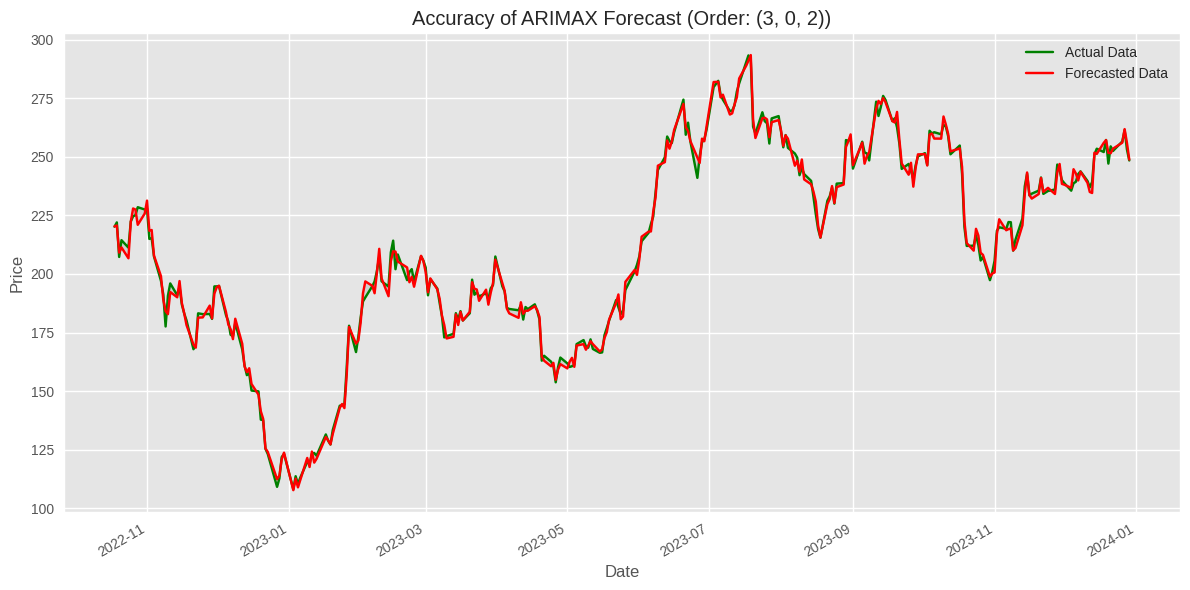

In [ ]:
# Plot forecast accuracy
arimax_model.plot_accuracy()

In [ ]:
# Print evaluation metrics
arimax_model.print_evaluation_metrics()

Final Mean Squared Error: 6.2247620593571815
Final Mean Absolute Error: 1.9620564719818199
Final Root Mean Squared Error: 2.494947305927959


In [ ]:
# Print model summary
arimax_model.print_model_summary()

                               ARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1208
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -2804.559
Date:                Thu, 22 Aug 2024   AIC                           5631.118
Time:                        22:06:46   BIC                           5687.182
Sample:                             0   HQIC                          5652.230
                               - 1208                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0783    1.1e-05  -7098.085      0.000      -0.078      -0.078
Open          -0.6737      0.004   -159.964      0.000      -0.682      -0.665
High           0.8701      0.001   1428.122      0.00

In [ ]:
# Display top model orders
arimax_model.display_top_orders(top_n=5)

Top 5 ARIMAX model orders with the lowest MSE:


,Order,MSE,MAE,RMSE,MAPE,SMAPE,MASE,R_Squared,Adj_R_Squared,AIC,BIC
110,"(3, 0, 2)",6.224762,1.962056,2.494947,0.952904,0.952402,0.359428,0.996565,0.996530,5631.118259,5687.182194
75,"(2, 0, 3)",6.231196,1.962894,2.496236,0.953291,0.952789,0.359581,0.996561,0.996526,5630.590144,5686.654079
77,"(2, 0, 5)",6.231803,1.962893,2.496358,0.953286,0.952787,0.359581,0.996561,0.996526,5633.208500,5699.465878
180,"(5, 0, 0)",6.232007,1.962989,2.496399,0.953335,0.952836,0.359598,0.996561,0.996526,5628.885587,5684.949523
181,"(5, 0, 1)",6.232448,1.962868,2.496487,0.953281,0.952782,0.359576,0.996560,0.996526,5630.913459,5692.074116


In [ ]:
# Get the best order and forecast
best_order = arimax_model.get_best_order()

In [ ]:
forecast = arimax_model.get_forecast()

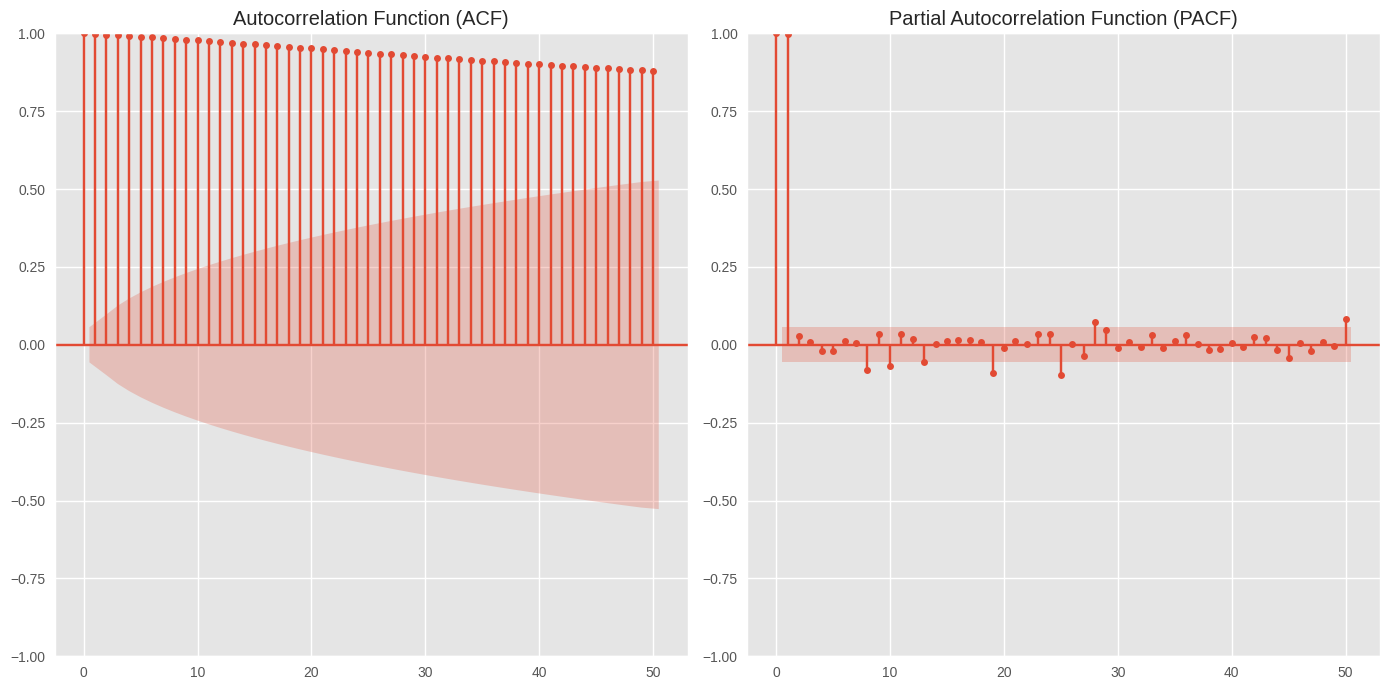

In [ ]:
# To plot the ACF and PACF:
arimax_model.plot_acf_pacf(lags=50)

In [ ]:
# # Extract the residuals
# residuals = arimax_model.resid

# # Plot ACF and PACF for the residuals
# plt.figure(figsize=(12, 6))

# plt.subplot(121)
# plot_acf(residuals, ax=plt.gca(), lags=40)
# plt.title('ACF of ARIMAX Residuals')

# plt.subplot(122)
# plot_pacf(residuals, ax=plt.gca(), lags=40)
# plt.title('PACF of ARIMAX Residuals')

# plt.tight_layout()
# plt.show()

## 4.3 Autoregressive fractionally integrated moving average (AFRIMA)

In [ ]:
class AFRIMAModel:
    def __init__(self, train, test, train_exog, test_exog, target_column, exog_vars):
        """
        Initializes the AFRIMAModel with the given parameters.

        Parameters:
        train (pd.DataFrame): The training dataset containing the target variable and exogenous variables.
        test (pd.DataFrame): The testing dataset containing the target variable and exogenous variables.
        train_exog (pd.DataFrame): The training exogenous variables.
        test_exog (pd.DataFrame): The testing exogenous variables.
        target_column (str): The name of the target variable in the train and test datasets.
        exog_vars (list): List of exogenous variables to include in the model.
        """
        self.train = pd.to_numeric(train[target_column], errors='coerce').dropna()
        self.test = pd.to_numeric(test[target_column], errors='coerce').dropna()
        self.train_exog = train_exog[exog_vars]
        self.test_exog = test_exog[exog_vars]
        self.exog_vars = exog_vars

        # If necessary, convert the index to datetime
        if not isinstance(self.train.index, pd.DatetimeIndex):
            self.train.index = pd.to_datetime(self.train.index)
        if not isinstance(self.test.index, pd.DatetimeIndex):
            self.test.index = pd.to_datetime(self.test.index)

        self.best_order = None
        self.best_rmse = float("inf")
        self.best_model = None
        self.forecast = None
        self.results_df = pd.DataFrame(columns=[
            'Order', 'MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE',
            'R_Squared', 'Adj_R_Squared', 'AIC', 'BIC'
        ])

    @staticmethod
    def mean_absolute_scaled_error(y_true, y_pred):
        """
        Calculates Mean Absolute Scaled Error (MASE).
        """
        n = len(y_true)
        d = np.abs(np.diff(y_true)).sum() / (n - 1)
        return np.abs(y_true - y_pred).mean() / d if d != 0 else float('inf')  # Avoid division by zero

    @staticmethod
    def symmetric_mean_absolute_percentage_error(y_true, y_pred):
        """
        Calculates Symmetric Mean Absolute Percentage Error (SMAPE).
        """
        return 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + np.finfo(float).eps))  # Avoid division by zero

    @staticmethod
    def adjusted_r_squared(r_squared, n, p):
        """
        Calculates Adjusted R-Squared.
        """
        return 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

    def evaluate_model(self, model, order):
        """
        Fits the model, makes forecasts, and evaluates performance metrics.
        """
        try:
            model_fit = model.fit(self.train, exogenous=self.train_exog)
            forecast = model_fit.predict_in_sample()
            mse = mean_squared_error(self.train, forecast)
            mae = mean_absolute_error(self.train, forecast)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((self.train - forecast) / self.train)) * 100 if not np.all(self.train == 0) else float('inf')  # Avoid division by zero
            smape = self.symmetric_mean_absolute_percentage_error(self.train, forecast)
            mase = self.mean_absolute_scaled_error(self.train, forecast)
            r_squared = r2_score(self.train, forecast)
            adj_r_squared = self.adjusted_r_squared(r_squared, len(self.train), len(order))
            aic_value = model_fit.aic()
            bic_value = model_fit.bic()

            return {
                'Order': order,
                'MSE': mse,
                'MAE': mae,
                'RMSE': rmse,
                'MAPE': mape,
                'SMAPE': smape,
                'MASE': mase,
                'R_Squared': r_squared,
                'Adj_R_Squared': adj_r_squared,
                'AIC': aic_value,
                'BIC': bic_value
            }
        except Exception as e:
            print(f"Error evaluating model with order (p={order[0]}, d={order[1]}, q={order[2]}): {e}")
            return None

    def grid_search(self):
        """
        Performs a grid search to find the most optimal AFRIMA model order based on the lowest MSE.
        """
        p = q = range(0, 6)  # p and q ranges for AR and MA components (0 to 5)
        d_values = np.linspace(0, 1, 6)  # Fractional differencing values from 0 to 1 (6 evenly spaced values)

        pdq = list(itertools.product(p, d_values, q))
        results = []

        for param in pdq:
            try:
                p, d, q = param
                model = auto_arima(self.train, exogenous=self.train_exog, order=(p, d, q), seasonal=False, suppress_warnings=True, with_intercept=False)
                evaluation = self.evaluate_model(model, param)
                if evaluation:
                    mse = evaluation['MSE']
                    print(f'AFRIMA(p={p}, d={d:.2f}, q={q}) MSE: {mse:.4f}')

                    results.append(evaluation)
                    if mse < self.best_rmse:
                        self.best_rmse = mse
                        self.best_order = param
                        self.best_model = model
            except Exception as e:
                print(f"Error evaluating model with order (p={p}, d={d:.2f}, q={q}): {e}")

        if results:
            self.results_df = pd.DataFrame(results)
            print(f"Best order found: {self.best_order} with MSE: {self.best_rmse:.4f}")
        else:
            print("No optimal order found.")


    def fit_best_model(self):
        """
        Fits the best AFRIMA model found during grid search.
        """
        if self.best_order is None:
            raise ValueError("Best order not found. Please run grid_search first.")
        self.best_model = auto_arima(self.train, exogenous=self.train_exog, order=self.best_order, seasonal=False, suppress_warnings=True, with_intercept=False)
        self.best_model = self.best_model.fit(self.train, exogenous=self.train_exog)

    def make_forecast(self):
        """
        Makes forecast using the best fitted AFRIMA model.
        """
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")
        self.forecast = self.best_model.predict(n_periods=len(self.test), exogenous=self.test_exog)

    def plot_results(self):
        """
        Plots the training data, validation data, and forecasted values, and indicates the AFRIMA (p, d, q) values.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")

        p, d, q = self.best_order  # Extract the p, d, q values

        plt.figure(figsize=(12, 6))
        plt.plot(self.train.index, self.train, label='Training Data')
        plt.plot(self.test.index, self.test, label='Validation Data')
        plt.plot(self.test.index, self.forecast, label='Forecast')
        plt.legend()

        # Title with AFRIMA order
        plt.title(f'Stock Price Forecast (AFRIMA Order: (p={p}, d={d}, q={q}))')

        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.gcf().autofmt_xdate()

        # Add text to indicate the p, d, q values on the plot
        plt.text(0.05, 0.95, f'AFRIMA Order: (p={p}, d={d}, q={q})', transform=plt.gca().transAxes,
                 fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        plt.tight_layout()
        plt.show()

    def plot_accuracy(self):
        """
        Plots the accuracy of the forecast by comparing predicted vs actual values.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        plt.figure(figsize=(12, 6))
        plt.plot(self.test.index, self.test, label='Actual Data', color='green')
        plt.plot(self.test.index, self.forecast, label='Forecasted Data', color='red')
        plt.fill_between(self.test.index, self.test, self.forecast, color='grey', alpha=0.2)
        plt.legend()
        plt.title(f'Accuracy of AFRIMA Forecast (Order: {self.best_order})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.gcf().autofmt_xdate()
        plt.tight_layout()
        plt.show()

    def print_evaluation_metrics(self):
        """
        Prints the evaluation metrics for the forecast.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        mse = mean_squared_error(self.test, self.forecast)
        mae = mean_absolute_error(self.test, self.forecast)
        rmse = np.sqrt(mse)
        print(f"Final Mean Squared Error: {mse}")
        print(f"Final Mean Absolute Error: {mae}")
        print(f"Final Root Mean Squared Error: {rmse}")

    def print_model_summary(self):
        """
        Prints the model summary and the parameters used.
        If 'SARIMAX' is found in the model summary, it is replaced with 'AFRIMA'.
        """
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")

        # Get the original summary
        original_summary = self.best_model.summary().as_text()

        # Replace 'SARIMAX' with 'AFRIMA' in the summary
        modified_summary = original_summary.replace("SARIMAX", "AFRIMA")

        # Print the modified summary
        print(modified_summary)

        # Extract and print coefficients
        print("\nModel Coefficients:")
        for param_name, value in zip(self.best_model.arima_res_.params.index, self.best_model.arima_res_.params):
            print(f"{param_name}: {value:.4f}")


    def display_top_orders(self, top_n=5):
        """
        Displays the top N AFRIMA model orders with the lowest MSE along with their evaluation metrics.

        Parameters:
        top_n (int): The number of top models to display.
        """
        if self.results_df.empty:
            raise ValueError("No results available. Please run grid_search first.")

        # Sort by MSE and select top N rows
        top_results = self.results_df.sort_values(by='MSE').head(top_n)

        # Display the top results DataFrame
        print(f"Top {top_n} AFRIMA model orders with the lowest MSE:")
        # display(top_results)

        return top_results

    def get_best_order(self):
        """
        Returns the best order found during grid search.
        """
        if self.best_order is None:
            raise ValueError("Best order not found. Please run grid_search first.")
        return self.best_order

    def get_forecast(self):
        """
        Returns the forecast made by the best fitted ARIMA model.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        return self.forecast

    def plot_acf_pacf(self, lags=40):
        """
        Plots the ACF and PACF of the training data.

        Parameters:
        lags (int): Number of lags to include in the plots.
        """
        plt.figure(figsize=(14, 7))

        plt.subplot(121)
        plot_acf(self.train, lags=lags, ax=plt.gca())
        plt.title('Autocorrelation Function (ACF)')

        plt.subplot(122)
        plot_pacf(self.train, lags=lags, ax=plt.gca())
        plt.title('Partial Autocorrelation Function (PACF)')

        plt.tight_layout()
        plt.show()

In [ ]:
exog_vars = ['Volume', 'Open', 'High', 'Low']

# # Exogenous variables
train_exog = train[exog_vars]
test_exog = test[exog_vars]

# Initialize the AFRIMAModel
afrima_model = AFRIMAModel(train, test, train_exog, test_exog, target_column, exog_vars)

In [ ]:
# Perform grid search
afrima_model.grid_search()

AFRIMA(p=0, d=0.00, q=0) MSE: 48.5013
AFRIMA(p=0, d=0.00, q=1) MSE: 48.5013
AFRIMA(p=0, d=0.00, q=2) MSE: 48.5013
AFRIMA(p=0, d=0.00, q=3) MSE: 48.5013
AFRIMA(p=0, d=0.00, q=4) MSE: 48.5013
AFRIMA(p=0, d=0.00, q=5) MSE: 48.5013
AFRIMA(p=0, d=0.20, q=0) MSE: 48.5013
AFRIMA(p=0, d=0.20, q=1) MSE: 48.5013
AFRIMA(p=0, d=0.20, q=2) MSE: 48.5013
AFRIMA(p=0, d=0.20, q=3) MSE: 48.5013
AFRIMA(p=0, d=0.20, q=4) MSE: 48.5013
AFRIMA(p=0, d=0.20, q=5) MSE: 48.5013
AFRIMA(p=0, d=0.40, q=0) MSE: 48.5013
AFRIMA(p=0, d=0.40, q=1) MSE: 48.5013
AFRIMA(p=0, d=0.40, q=2) MSE: 48.5013
AFRIMA(p=0, d=0.40, q=3) MSE: 48.5013
AFRIMA(p=0, d=0.40, q=4) MSE: 48.5013
AFRIMA(p=0, d=0.40, q=5) MSE: 48.5013
AFRIMA(p=0, d=0.60, q=0) MSE: 48.5013
AFRIMA(p=0, d=0.60, q=1) MSE: 48.5013
AFRIMA(p=0, d=0.60, q=2) MSE: 48.5013
AFRIMA(p=0, d=0.60, q=3) MSE: 48.5013
AFRIMA(p=0, d=0.60, q=4) MSE: 48.5013
AFRIMA(p=0, d=0.60, q=5) MSE: 48.5013
AFRIMA(p=0, d=0.80, q=0) MSE: 48.5013
AFRIMA(p=0, d=0.80, q=1) MSE: 48.5013
AFRIMA(p=0, 

In [ ]:
top_orders = afrima_model.display_top_orders()

Top 5 AFRIMA model orders with the lowest MSE:


In [ ]:
top_orders

,Order,MSE,MAE,RMSE,MAPE,SMAPE,MASE,R_Squared,Adj_R_Squared,AIC,BIC
0,"(0, 0.0, 0)",48.501301,3.81636,6.964288,2.945515,3.028689,1.003825,0.996611,0.996603,8103.953446,8109.049339
137,"(3, 0.8, 5)",48.501301,3.81636,6.964288,2.945515,3.028689,1.003825,0.996611,0.996603,8103.953446,8109.049339
138,"(3, 1.0, 0)",48.501301,3.81636,6.964288,2.945515,3.028689,1.003825,0.996611,0.996603,8103.953446,8109.049339
139,"(3, 1.0, 1)",48.501301,3.81636,6.964288,2.945515,3.028689,1.003825,0.996611,0.996603,8103.953446,8109.049339
140,"(3, 1.0, 2)",48.501301,3.81636,6.964288,2.945515,3.028689,1.003825,0.996611,0.996603,8103.953446,8109.049339
